In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import shap
from tqdm import tqdm
from scipy import stats

# Sklearn imports
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

# Other ML libraries
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Optuna imports
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Set pandas display options
pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.basicConfig(level=logging.WARNING)

In [3]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ
df = pd.read_excel('data.xlsx')

In [4]:
df

Unnamed: 0    IC50, mM    CC50, mM         SI  MaxAbsEStateIndex  \
0              0    6.239374  175.482382  28.125000           5.094096   
1              1    0.771831    5.402819   7.000000           3.961417   
2              2  223.808778  161.142320   0.720000           2.627117   
3              3    1.705624  107.855654  63.235294           5.097360   
4              4  107.131532  139.270991   1.300000           5.150510   
...          ...         ...         ...        ...                ...   
996          996   31.000104   34.999650   1.129017          12.934891   
997          997   31.999934   33.999415   1.062484          13.635345   
998          998   30.999883   33.999458   1.096761          13.991690   
999          999   31.998959   32.999644   1.031272          13.830180   
1000        1000   99.999531   99.999531   1.000000          13.380863   

      MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0           5.094096           0.387225        0.387225  0.417362  42.928571   
1           3.961417           0.533868        0.533868  0.462473  45.214286   
2           2.627117           0.543231        0.543231  0.260923  42.187500   
3           5.097360           0.390603        0.390603  0.377846  41.862069   
4           5.150510           0.270476        0.270476  0.429038  36.514286   
...              ...                ...             ...       ...        ...   
996        12.934891           0.048029       -0.476142  0.382752  49.133333   
997        13.635345           0.030329       -0.699355  0.369425  44.542857   
998        13.991690           0.026535       -0.650790  0.284923  41.973684   
999        13.830180           0.146522       -1.408652  0.381559  39.000000   
1000       13.380863           0.002425       -0.447978  0.452565  48.580645   

        MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  \
0     384.652         340.300  384.350449                  158   
1     388.684         340.300  388.381750                  162   
2     446.808         388.344  446.458903                  186   
3     398.679         352.311  398.366099                  164   
4     466.713         424.377  466.334799                  184   
...       ...             ...         ...                  ...   
996   414.542         380.270  414.240624                  164   
997   485.621         446.309  485.277738                  192   
998   545.742         502.398  545.281109                  210   
999   522.635         480.299  522.282883                  208   
1000  426.597         388.293  426.277010                  170   

      NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  \
0                       0          0.038844         -0.293526   
1                       0          0.012887         -0.313407   
2                       0          0.094802         -0.325573   
3                       0          0.038844         -0.293526   
4                       0          0.062897         -0.257239   
...                   ...               ...               ...   
996                     0          0.317890         -0.468587   
997                     0          0.327562         -0.467493   
998                     0          0.327887         -0.467485   
999                     0          0.312509         -0.468755   
1000                    0          0.311311         -0.468587   

      MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  \
0                0.293526             0.038844          0.642857   
1                0.313407             0.012887          0.607143   
2                0.325573             0.094802          0.562500   
3                0.293526             0.038844          0.620690   
4                0.257239             0.062897          0.600000   
...                   ...                  ...               ...   
996              0.468587             0.317890          1.133333   
997              0.467493             

–î–∞–Ω–Ω—ã–µ —Å–æ–¥–µ—Ä–∂–∞—Ç 1001 —Å—Ç—Ä–æ–∫—É –∏ 214 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤. –°—Ä–∞–∑—É –º–æ–∂–Ω–æ –æ—Ç–º–µ—Ç–∏—Ç—å –Ω–µ–∏–Ω—Ñ–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫ "Unnamed: 0".

In [6]:
# –£–¥–∞–ª—è–µ–º –Ω–µ–º–Ω—Ñ–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫
df = df.drop(columns = ['Unnamed: 0'])

In [7]:
# –£–¥–∞–ª—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏
df = df.dropna()

In [8]:
df.shape

(998, 213)

In [9]:
# –£–¥–∞–ª—è–µ–º –¥—É–±–ª–∏–∫–∞—Ç—ã
df = df.drop_duplicates()

In [10]:
df.shape

(966, 213)

In [11]:
def detect_outliers(df, alpha=0.05, method='iqr', normality_test='shapiro', add_sum_column=False):
    """
    –û–±–Ω–∞—Ä—É–∂–µ–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤ –≤ DataFrame —Å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ–º —Ä–∞–∑–ª–∏—á–Ω—ã—Ö —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏—Ö –º–µ—Ç–æ–¥–æ–≤.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : pandas.DataFrame
        –í—Ö–æ–¥–Ω–æ–π DataFrame —Å –¥–∞–Ω–Ω—ã–º–∏ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞
    alpha : float, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.05
        –£—Ä–æ–≤–µ–Ω—å –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –¥–ª—è —Ç–µ—Å—Ç–æ–≤ –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å
    method : str, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 'iqr'
        –ú–µ—Ç–æ–¥ –æ–±–Ω–∞—Ä—É–∂–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤ –¥–ª—è –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö:
        - 'iqr' - –º–µ—Ç–æ–¥ –º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–∞—Ö–∞
        - 'zscore' - –º–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score
    normality_test : str, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 'shapiro'
        –¢–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è:
        - 'shapiro' - —Ç–µ—Å—Ç –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫–∞
        - 'normaltest' - —Ç–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å D'Agostino-Pearson
        - 'anderson' - —Ç–µ—Å—Ç –ê–Ω–¥–µ—Ä—Å–æ–Ω–∞-–î–∞—Ä–ª–∏–Ω–≥–∞
    add_sum_column : bool, –ø–æ —É–º–æ–ª—á–∞–Ω–∏—é False
        –ï—Å–ª–∏ True, –¥–æ–±–∞–≤–ª—è–µ—Ç —Å—Ç–æ–ª–±–µ—Ü —Å –æ–±—â–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –≤—ã–±—Ä–æ—Å–æ–≤ –¥–ª—è –∫–∞–∂–¥–æ–π —Å—Ç—Ä–æ–∫–∏
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pandas.DataFrame
        DataFrame —Å –±—É–ª–µ–≤—ã–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏, –≥–¥–µ True —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –≤—ã–±—Ä–æ—Å
    """
    
    # –°–æ–∑–¥–∞–µ–º DataFrame –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é –≤—Å–µ –∑–Ω–∞—á–µ–Ω–∏—è False)
    outliers = pd.DataFrame(False, index=df.index, columns=df.columns)
    
    # –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ–º –∫–∞–∂–¥—ã–π —Å—Ç–æ–ª–±–µ—Ü –æ—Ç–¥–µ–ª—å–Ω–æ
    for col in df.columns:
        # –£–¥–∞–ª—è–µ–º –ø—Ä–æ–ø—É—â–µ–Ω–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ —Å—Ç–æ–ª–±—Ü–∞
        data = df[col].dropna()
        
        # –ï—Å–ª–∏ –≤ —Å—Ç–æ–ª–±—Ü–µ –º–µ–Ω—å—à–µ 3 –∑–Ω–∞—á–µ–Ω–∏–π, –ø—Ä–æ–ø—É—Å–∫–∞–µ–º –µ–≥–æ
        if len(data) < 3:
            continue
            
        # –ü—Ä–æ–≤–µ—Ä—è–µ–º –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
        normal = False  # –§–ª–∞–≥ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è
        
        try:
            # –í—ã–±–∏—Ä–∞–µ–º —Ç–µ—Å—Ç –Ω–∞ –Ω–æ—Ä–º–∞–ª—å–Ω–æ—Å—Ç—å –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ normality_test
            if normality_test == 'shapiro':
                # –¢–µ—Å—Ç –®–∞–ø–∏—Ä–æ-–£–∏–ª–∫–∞ (–ø–æ–¥—Ö–æ–¥–∏—Ç –¥–ª—è –Ω–µ–±–æ–ª—å—à–∏—Ö –≤—ã–±–æ—Ä–æ–∫ < 5000)
                _, p = stats.shapiro(data)
                normal = p > alpha  # –ï—Å–ª–∏ p-value > alpha, —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å—á–∏—Ç–∞–µ—Ç—Å—è –Ω–æ—Ä–º–∞–ª—å–Ω—ã–º
                
            elif normality_test == 'normaltest':
                # –¢–µ—Å—Ç D'Agostino-Pearson (—Ä–∞–±–æ—Ç–∞–µ—Ç –¥–ª—è –≤—ã–±–æ—Ä–æ–∫ > 20)
                _, p = stats.normaltest(data)
                normal = p > alpha
                
            elif normality_test == 'anderson':
                # –¢–µ—Å—Ç –ê–Ω–¥–µ—Ä—Å–æ–Ω–∞-–î–∞—Ä–ª–∏–Ω–≥–∞ (–±–æ–ª–µ–µ —Å—Ç—Ä–æ–≥–∏–π)
                result = stats.anderson(data)
                # –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫—É —Å –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏–º –∑–Ω–∞—á–µ–Ω–∏–µ–º –¥–ª—è –≤—ã–±—Ä–∞–Ω–Ω–æ–≥–æ alpha
                normal = result.statistic < result.critical_values[np.where(result.significance_level == int(alpha*100))[0][0]]
        except:
            # –í —Å–ª—É—á–∞–µ –æ—à–∏–±–∫–∏ –≤ —Ç–µ—Å—Ç–µ —Å—á–∏—Ç–∞–µ–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã–º
            pass
        
        # –ï—Å–ª–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ, –∏—Å–ø–æ–ª—å–∑—É–µ–º —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–π Z-score
        if normal:
            z = np.abs(stats.zscore(data))  # –í—ã—á–∏—Å–ª—è–µ–º Z-–æ—Ü–µ–Ω–∫–∏
            outliers.loc[data.index, col] = z > 3  # –í—ã–±—Ä–æ—Å—ã > 3 —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã—Ö –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–π
            
        # –î–ª—è –Ω–µ–Ω–æ—Ä–º–∞–ª—å–Ω—ã—Ö —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–π –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤—ã–±—Ä–∞–Ω–Ω—ã–π –º–µ—Ç–æ–¥
        else:
            if method == 'iqr':
                # –ú–µ—Ç–æ–¥ –º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω–æ–≥–æ —Ä–∞–∑–º–∞—Ö–∞ (IQR)
                q1 = data.quantile(0.25)  # –ü–µ—Ä–≤—ã–π –∫–≤–∞—Ä—Ç–∏–ª—å (25-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å)
                q3 = data.quantile(0.75)  # –¢—Ä–µ—Ç–∏–π –∫–≤–∞—Ä—Ç–∏–ª—å (75-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å)
                iqr = q3 - q1  # –ú–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö
                
                # –ì—Ä–∞–Ω–∏—Ü—ã –¥–ª—è –≤—ã–±—Ä–æ—Å–æ–≤
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                
                # –û—Ç–º–µ—á–∞–µ–º –≤—ã–±—Ä–æ—Å—ã
                outliers.loc[data.index, col] = (data < lower_bound) | (data > upper_bound)
                
            elif method == 'zscore':
                # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score (–±–æ–ª–µ–µ —É—Å—Ç–æ–π—á–∏–≤—ã–π –∫ –≤—ã–±—Ä–æ—Å–∞–º)
                median = data.median()  # –ú–µ–¥–∏–∞–Ω–∞ –≤–º–µ—Å—Ç–æ —Å—Ä–µ–¥–Ω–µ–≥–æ
                mad = stats.median_abs_deviation(data, scale='normal')  # –ú–µ–¥–∏–∞–Ω–Ω–æ–µ –∞–±—Å–æ–ª—é—Ç–Ω–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ
                modified_z = np.abs(0.6745 * (data - median) / mad)  # –ú–æ–¥–∏—Ñ–∏—Ü–∏—Ä–æ–≤–∞–Ω–Ω—ã–π Z-score
                
                # –í—ã–±—Ä–æ—Å—ã –ø—Ä–∏ modified_z > 3.5
                outliers.loc[data.index, col] = modified_z > 3.5
    
    # –î–æ–±–∞–≤–ª—è–µ–º —Å—Ç–æ–ª–±–µ—Ü —Å —Å—É–º–º–æ–π –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ —Å—Ç—Ä–æ–∫–∞–º, –µ—Å–ª–∏ –Ω—É–∂–Ω–æ
    if add_sum_column:
        outliers['outliers_sum'] = outliers.sum(axis=1)
    
    return outliers
# –ù–∞—Ö–æ–¥–∏–º –≤—ã–±—Ä–æ—Å—ã
outliers = detect_outliers(df)

# –í—ã–≤–æ–¥–∏–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –∫–∞–∂–¥–æ–º—É –ø—Ä–∏–∑–Ω–∞–∫—É
print("\n–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º:")
print(outliers.sum())



–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º:
IC50, mM             140
CC50, mM              35
SI                   119
MaxAbsEStateIndex     60
MaxEStateIndex        60
                    ... 
fr_thiazole           52
fr_thiocyan            0
fr_thiophene          68
fr_unbrch_alkane      49
fr_urea                7
Length: 213, dtype: int64


In [12]:
def validate_molecular_descriptors(df):
    """
    –ü—Ä–æ–≤–æ–¥–∏—Ç –ø—Ä–æ–≤–µ—Ä–∫—É –¥–∞–Ω–Ω—ã—Ö –Ω–∞ –Ω–∞–ª–∏—á–∏–µ —à—É–º–æ–≤.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : pd.DataFrame
        DataFrame —Å –º–æ–ª–µ–∫—É–ª—è—Ä–Ω—ã–º–∏ –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä–∞–º–∏ (213 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    tuple: (DataFrame —Å –æ—à–∏–±–∫–∞–º–∏, DataFrame —Å –∏—Ç–æ–≥–æ–≤–æ–π —Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–æ–π)
    """
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è —Å–ª–æ–≤–∞—Ä—è –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –æ—à–∏–±–æ–∫
    errors = {
        'row_index': [],
        'descriptor': [],
        'value': [],
        'error_type': [],
        'expected_range': []
    }
    
    # –ü–æ–ª–Ω—ã–π —Å–ø–∏—Å–æ–∫ –≤—Å–µ—Ö 213 –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    all_descriptors = [
        'IC50, mM', 'CC50, mM', 'SI', 'MaxAbsEStateIndex', 'MaxEStateIndex', 
        'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 
        'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons',
        'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
        'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI',
        'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW',
        'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n',
        'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
        'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
        'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14',
        'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7',
        'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3',
        'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9',
        'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2',
        'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7',
        'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'EState_VSA1', 'EState_VSA10',
        'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5',
        'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'VSA_EState1',
        'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5',
        'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'FractionCSP3',
        'HeavyAtomCount', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
        'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles',
        'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors',
        'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
        'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP', 'MolMR',
        'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N',
        'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S',
        'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1',
        'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate',
        'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
        'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene',
        'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide',
        'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine',
        'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan',
        'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy',
        'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho',
        'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol',
        'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine',
        'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN',
        'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
        'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea'
    ]

    # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –¥–æ–ø—É—Å—Ç–∏–º—ã—Ö –¥–∏–∞–ø–∞–∑–æ–Ω–æ–≤ –¥–ª—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    descriptor_ranges = {
        # –û—Å–Ω–æ–≤–Ω—ã–µ —Ñ–∏–∑–∏–∫–æ-—Ö–∏–º–∏—á–µ—Å–∫–∏–µ —Å–≤–æ–π—Å—Ç–≤–∞
        'MolWt': (0, 2000, "–ú–æ–ª–µ–∫—É–ª—è—Ä–Ω—ã–π –≤–µ—Å"),
        'ExactMolWt': (0, 2000, "–¢–æ—á–Ω—ã–π –º–æ–ª–µ–∫—É–ª—è—Ä–Ω—ã–π –≤–µ—Å"),
        'HeavyAtomMolWt': (0, 2000, "–í–µ—Å —Ç—è–∂–µ–ª—ã—Ö –∞—Ç–æ–º–æ–≤"),
        'MolLogP': (-15, 15, "–õ–æ–≥–∞—Ä–∏—Ñ–º –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è"),
        'MolMR': (0, 500, "–ú–æ–ª–µ–∫—É–ª—è—Ä–Ω–∞—è —Ä–µ—Ñ—Ä–∞–∫—Ü–∏—è"),
        'TPSA': (0, 1000, "–ü–æ–ª—è—Ä–Ω–∞—è –ø–ª–æ—â–∞–¥—å –ø–æ–≤–µ—Ä—Ö–Ω–æ—Å—Ç–∏"),
        'qed': (0, 1, "–ö–≤–∞–Ω—Ç–æ–≤–∞—è –º–µ—Ä–∞ —Å—Ö–æ–¥—Å—Ç–≤–∞ —Å –ª–µ–∫–∞—Ä—Å—Ç–≤–æ–º"),
        'FractionCSP3': (0, 1, "–î–æ–ª—è sp3-–≥–∏–±—Ä–∏–¥–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∞—Ç–æ–º–æ–≤ —É–≥–ª–µ—Ä–æ–¥–∞"),
        
        # –ë–∏–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–µ –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏
        'IC50, mM': (0, 100, "–ü–æ–ª—É–º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –∏–Ω–≥–∏–±–∏—Ä—É—é—â–∞—è –∫–æ–Ω—Ü–µ–Ω—Ç—Ä–∞—Ü–∏—è"),
        'CC50, mM': (0, 100, "–¶–∏—Ç–æ—Ç–æ–∫—Å–∏—á–µ—Å–∫–∞—è –∫–æ–Ω—Ü–µ–Ω—Ç—Ä–∞—Ü–∏—è"),
        'SI': (0, 1000, "–ò–Ω–¥–µ–∫—Å —Å–µ–ª–µ–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏"),
        
        # –≠–ª–µ–∫—Ç—Ä–æ–Ω–Ω—ã–µ —Å–≤–æ–π—Å—Ç–≤–∞ –∏ –∑–∞—Ä—è–¥—ã
        'MaxPartialCharge': (-2, 2, "–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π –ø–∞—Ä—Ü–∏–∞–ª—å–Ω—ã–π –∑–∞—Ä—è–¥"),
        'MinPartialCharge': (-2, 2, "–ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π –ø–∞—Ä—Ü–∏–∞–ª—å–Ω—ã–π –∑–∞—Ä—è–¥"),
        'MaxAbsPartialCharge': (0, 2, "–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π –∞–±—Å–æ–ª—é—Ç–Ω—ã–π –∑–∞—Ä—è–¥"),
        'MinAbsPartialCharge': (0, 2, "–ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π –∞–±—Å–æ–ª—é—Ç–Ω—ã–π –∑–∞—Ä—è–¥"),
        'NumValenceElectrons': (0, 500, "–í–∞–ª–µ–Ω—Ç–Ω—ã–µ —ç–ª–µ–∫—Ç—Ä–æ–Ω—ã"),
        'NumRadicalElectrons': (0, 20, "–ù–µ—Å–ø–∞—Ä–µ–Ω–Ω—ã–µ —ç–ª–µ–∫—Ç—Ä–æ–Ω—ã"),
        
        # –¢–æ–ø–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–µ –∏–Ω–¥–µ–∫—Å—ã
        'BalabanJ': (0, 20, "–ò–Ω–¥–µ–∫—Å –ë–∞–ª–∞–±–∞–Ω–∞"),
        'BertzCT': (0, 5000, "–ò–Ω–¥–µ–∫—Å —Å–ª–æ–∂–Ω–æ—Å—Ç–∏ –ë–µ—Ä—Ü–∞"),
        'Ipc': (0, 1e6, "–ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏–æ–Ω–Ω—ã–π –∏–Ω–¥–µ–∫—Å"),
        'HallKierAlpha': (-5, 5, "–ò–Ω–¥–µ–∫—Å –•–æ–ª–ª–∞-–ö–∏–µ—Ä–∞"),
        'Kappa1': (0, 100, "–ö–∞–ø–ø–∞-1 –∏–Ω–¥–µ–∫—Å"),
        'Kappa2': (0, 100, "–ö–∞–ø–ø–∞-2 –∏–Ω–¥–µ–∫—Å"),
        'Kappa3': (0, 100, "–ö–∞–ø–ø–∞-3 –∏–Ω–¥–µ–∫—Å"),
        
       # BCUT –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä—ã
        **{f'BCUT2D_{prop}': (-10, 10, f"BCUT 2D {prop}") 
           for prop in ['MWHI', 'MWLOW', 'CHGHI', 'CHGLO', 'LOGPHI', 'LOGPLOW', 'MRHI', 'MRLOW']},
        
        # VSA –∏ EState –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä—ã
        **{f'{prefix}_VSA{num}': (-100, 100, f"{prefix} VSA {num}") 
           for prefix in ['PEOE', 'SMR', 'SlogP', 'EState'] 
           for num in range(1,15) if not (prefix == 'SMR' and num == 9)},
        
        # –§—Ä–∞–≥–º–µ–Ω—Ç–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ (–¥–æ–ª–∂–Ω—ã –±—ã—Ç—å >= 0)
        **{f'fr_{name}': (0, 50, f"–§—Ä–∞–≥–º–µ–Ω—Ç {name}") for name in [
            col.replace('fr_','') for col in all_descriptors if col.startswith('fr_')
        ]},
        
        # –ö–æ–ª–∏—á–µ—Å—Ç–≤–µ–Ω–Ω—ã–µ –ø–æ–¥—Å—á–µ—Ç—ã
        'HeavyAtomCount': (0, 500, "–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç—è–∂–µ–ª—ã—Ö –∞—Ç–æ–º–æ–≤"),
        'NHOHCount': (0, 50, "–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ OH/NH –≥—Ä—É–ø–ø"),
        'NOCount': (0, 50, "–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∞–∑–æ—Ç–∞ –∏ –∫–∏—Å–ª–æ—Ä–æ–¥–∞"),
        'NumHAcceptors': (0, 50, "–ê–∫—Ü–µ–ø—Ç–æ—Ä—ã –≤–æ–¥–æ—Ä–æ–¥–∞"),
        'NumHDonors': (0, 50, "–î–æ–Ω–æ—Ä—ã –≤–æ–¥–æ—Ä–æ–¥–∞"),
        'NumHeteroatoms': (0, 100, "–ì–µ—Ç–µ—Ä–æ–∞—Ç–æ–º—ã"),
        'NumRotatableBonds': (0, 50, "–í—Ä–∞—â–∞—é—â–∏–µ—Å—è —Å–≤—è–∑–∏"),
        'RingCount': (0, 20, "–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ü–∏–∫–ª–æ–≤"),
        'NumAliphaticRings': (0, 20, "–ê–ª–∏—Ñ–∞—Ç–∏—á–µ—Å–∫–∏–µ —Ü–∏–∫–ª—ã"),
        'NumAromaticRings': (0, 20, "–ê—Ä–æ–º–∞—Ç–∏—á–µ—Å–∫–∏–µ —Ü–∏–∫–ª—ã"),
        'NumSaturatedRings': (0, 20, "–ù–∞—Å—ã—â–µ–Ω–Ω—ã–µ —Ü–∏–∫–ª—ã"),
        
        # –ü—Ä–æ—á–∏–µ –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä—ã
        'SPS': (0, 500, "–†–∞–∑–º–µ—Ä –º–æ–ª–µ–∫—É–ª—ã"),
        'MaxEStateIndex': (-50, 50, "–ú–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–π EState –∏–Ω–¥–µ–∫—Å"),
        'MinEStateIndex': (-50, 50, "–ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–π EState –∏–Ω–¥–µ–∫—Å"),
        'FpDensityMorgan1': (0, 100, "–ü–ª–æ—Ç–Ω–æ—Å—Ç—å –æ—Ç–ø–µ—á–∞—Ç–∫–æ–≤ Morgan1"),
        'FpDensityMorgan2': (0, 100, "–ü–ª–æ—Ç–Ω–æ—Å—Ç—å –æ—Ç–ø–µ—á–∞—Ç–∫–æ–≤ Morgan2"),
        'FpDensityMorgan3': (0, 100, "–ü–ª–æ—Ç–Ω–æ—Å—Ç—å –æ—Ç–ø–µ—á–∞—Ç–∫–æ–≤ Morgan3")
    }

    # –§—É–Ω–∫—Ü–∏—è –¥–ª—è –¥–æ–±–∞–≤–ª–µ–Ω–∏—è –æ—à–∏–±–∫–∏
    def add_error(index, desc, value, err_type, expected):
        errors['row_index'].append(index)
        errors['descriptor'].append(desc)
        errors['value'].append(value)
        errors['error_type'].append(err_type)
        errors['expected_range'].append(expected)

    # –û—Å–Ω–æ–≤–Ω–æ–π —Ü–∏–∫–ª –ø—Ä–æ–≤–µ—Ä–∫–∏
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="–ê–Ω–∞–ª–∏–∑ –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä–æ–≤"):
        for desc in all_descriptors:
            if desc not in df.columns:
                continue
                
            value = row[desc]
            
            # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ NaN (—Ö–æ—Ç—è –≤—ã —Å–∫–∞–∑–∞–ª–∏, —á—Ç–æ –∏—Ö –Ω–µ—Ç)
            if pd.isna(value):
                add_error(idx, desc, value, 'Missing value', 'Not NaN')
                continue
            
            # –ü—Ä–æ–≤–µ—Ä–∫–∞ –¥–∏–∞–ø–∞–∑–æ–Ω–æ–≤
            if desc in descriptor_ranges:
                min_val, max_val, _ = descriptor_ranges[desc]
                if not (min_val <= value <= max_val):
                    add_error(idx, desc, value, 'Value out of range', 
                             f'{min_val}-{max_val}')
            
            # –°–ø–µ—Ü–∏–∞–ª—å–Ω—ã–µ –ø—Ä–æ–≤–µ—Ä–∫–∏ –¥–ª—è —Ñ—Ä–∞–≥–º–µ–Ω—Ç–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
            if desc.startswith('fr_') and value < 0:
                add_error(idx, desc, value, 'Negative count', '>=0')
                
            # –ü—Ä–æ–≤–µ—Ä–∫–∞ —Ü–µ–ª–æ—á–∏—Å–ª–µ–Ω–Ω–æ—Å—Ç–∏ –¥–ª—è —Å—á–µ—Ç–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
            count_descriptors = [d for d in all_descriptors if 
                                d.startswith('Num') or 
                                d.startswith('fr_') or 
                                d in ['HeavyAtomCount', 'NHOHCount', 'NOCount', 'RingCount',
                                     'NumAliphaticRings', 'NumAromaticRings', 'NumSaturatedRings']]
            if desc in count_descriptors and not float(value).is_integer():
                add_error(idx, desc, value, 'Non-integer value', 'Integer expected')

    # –°–æ–∑–¥–∞–Ω–∏–µ DataFrame —Å –æ—à–∏–±–∫–∞–º–∏
    errors_df = pd.DataFrame(errors)
    
    # –ì—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∞ –æ—à–∏–±–æ–∫ –ø–æ —Å—Ç—Ä–æ–∫–∞–º –¥–ª—è –∏—Ç–æ–≥–æ–≤–æ–≥–æ –æ—Ç—á–µ—Ç–∞
    if not errors_df.empty:
        error_stats = errors_df.groupby('row_index').agg({
            'error_type': lambda x: ', '.join(set(x)),
            'descriptor': lambda x: f"{len(set(x))} descriptors",
            'value': 'count'
        }).rename(columns={'value': 'error_count'})
    else:
        error_stats = pd.DataFrame(columns=['error_type', 'descriptor', 'error_count'])
    
    return errors_df, error_stats

# –ó–∞–ø—É—Å–∫ –ø—Ä–æ–≤–µ—Ä–∫–∏ –∏ –≤—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤:
errors, stats = validate_molecular_descriptors(df)
print("–û–±–Ω–∞—Ä—É–∂–µ–Ω–æ –æ—à–∏–±–æ–∫:", len(errors))
print("–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —Å—Ç—Ä–æ–∫–∞–º:")
print(stats.sort_values('error_count', ascending=False).head(5))


–ê–Ω–∞–ª–∏–∑ –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä–æ–≤: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 966/966 [00:09<00:00, 104.19it/s]

–û–±–Ω–∞—Ä—É–∂–µ–Ω–æ –æ—à–∏–±–æ–∫: 2776
–°—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞ –ø–æ —Å—Ç—Ä–æ–∫–∞–º:
                   error_type      descriptor  error_count
row_index                                                 
843        Value out of range  10 descriptors           10
8          Value out of range   9 descriptors            9
987        Value out of range   9 descriptors            9
57         Value out of range   8 descriptors            8
60         Value out of range   8 descriptors            8


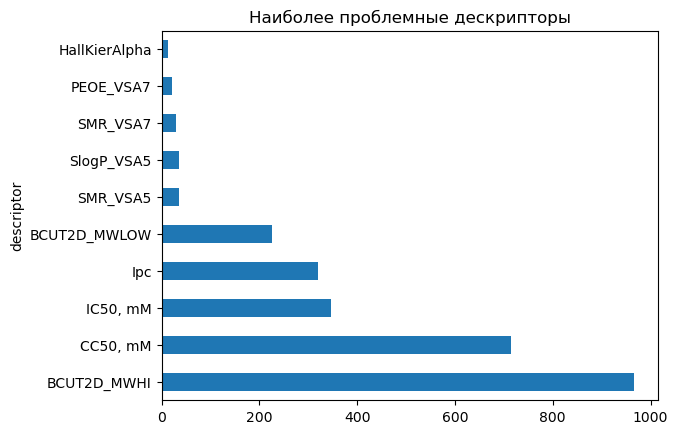

In [13]:
# –¢–æ–ø-10 –ø—Ä–æ–±–ª–µ–º–Ω—ã—Ö –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä–æ–≤
errors['descriptor'].value_counts().head(10).plot(kind='barh')
plt.title('–ù–∞–∏–±–æ–ª–µ–µ –ø—Ä–æ–±–ª–µ–º–Ω—ã–µ –¥–µ—Å–∫—Ä–∏–ø—Ç–æ—Ä—ã')
plt.show()


–ï—Å—Ç—å –ø–æ–¥–æ–∑—Ä–µ–Ω–∏—è –Ω–∞ –Ω–∞–ª–∏—á–∏–µ –æ—à–∏–±–æ–∫ –≤ –¥–∞–Ω–Ω—ã—Ö, –æ–¥–Ω–æ–∑–Ω–∞—á–Ω–æ –æ—Ç–≤–µ—Ç–∏—Ç—å –Ω–∞ —ç—Ç–æ—Ç –≤–æ–ø—Ä–æ—Å –º–µ—à–∞–µ—Ç –Ω–µ–ø–æ–Ω–∏–º–∞–Ω–∏–µ –ø—Ä–æ—Ü–µ—Å–æ–≤ –ø—Ä–æ–≤–æ–¥–∏–º—ã—Ö –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π –ø—Ä–∏ —Å–æ–∑–¥–∞–Ω–∏–∏ –ª–µ–∫–∞—Ä—Å—Ç–≤–µ–Ω–Ω—ã—Ö —Å—Ä–µ–¥—Å—Ç–≤.

In [15]:
def remove_highly_correlated_features(df, target_col, threshold=0.8):
    """
    –£–¥–∞–ª—è–µ—Ç –æ–¥–∏–Ω –∏–∑ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ –≤—ã—Å–æ–∫–æ–∫–æ—Ä—Ä–µ–ª–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –ø–∞—Ä–∞—Ö, —Å–æ—Ö—Ä–∞–Ω—è—è –ø—Ä–∏–∑–Ω–∞–∫ —Å –±–æ–ª–µ–µ –≤—ã—Å–æ–∫–æ–π 
    –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–µ–π —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : DataFrame
        –í—Ö–æ–¥–Ω–æ–π DataFrame —Å –¥–∞–Ω–Ω—ã–º–∏
    target_col : str
        –ù–∞–∑–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞ —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
    threshold : float, optional
        –ü–æ—Ä–æ–≥ –¥–ª—è –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è –≤—ã—Å–æ–∫–∏—Ö –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –º–µ–∂–¥—É –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.8)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    DataFrame —Å —É–¥–∞–ª–µ–Ω–Ω—ã–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏
    """
    # –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
    if target_col not in df.columns:
        raise ValueError(f"–¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è '{target_col}' –Ω–µ –Ω–∞–π–¥–µ–Ω–∞ –≤ DataFrame")
    
    # –í—ã—á–∏—Å–ª—è–µ–º –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏
    corr_matrix = df.corr(numeric_only=True)
    target_corrs = corr_matrix[target_col].abs().drop(target_col)
    
    # –ü–æ–ª—É—á–∞–µ–º –º–∞—Ç—Ä–∏—Ü—É –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –º–µ–∂–¥—É –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ (–±–µ–∑ —Ü–µ–ª–µ–≤–æ–π)
    feature_corr = df.drop(columns=[target_col]).corr(numeric_only=True).abs()
    np.fill_diagonal(feature_corr.values, 0)  # –û–±–Ω—É–ª—è–µ–º –¥–∏–∞–≥–æ–Ω–∞–ª—å
    
    # –ù–∞—Ö–æ–¥–∏–º –ø–∞—Ä—ã —Å –≤—ã—Å–æ–∫–æ–π –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–µ–π
    high_corr_pairs = (feature_corr > threshold).stack()
    high_corr_pairs = high_corr_pairs[high_corr_pairs].index
    
    # –°–æ–±–∏—Ä–∞–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è —É–¥–∞–ª–µ–Ω–∏—è
    to_drop = set()
    
    # –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º –∫–∞–∂–¥—É—é –ø–∞—Ä—É
    for f1, f2 in high_corr_pairs:
        # –£–∂–µ –ø–æ–º–µ—á–µ–Ω –Ω–∞ —É–¥–∞–ª–µ–Ω–∏–µ - –ø—Ä–æ–ø—É—Å–∫–∞–µ–º
        if f1 in to_drop or f2 in to_drop:
            continue
            
        # –°—Ä–∞–≤–Ω–∏–≤–∞–µ–º –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π
        corr_f1 = target_corrs.get(f1, 0)
        corr_f2 = target_corrs.get(f2, 0)
        
        # –£–¥–∞–ª—è–µ–º –ø—Ä–∏–∑–Ω–∞–∫ —Å –º–µ–Ω—å—à–µ–π –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–µ–π —Å —Ü–µ–ª–µ–≤–æ–π
        if corr_f1 > corr_f2:
            to_drop.add(f2)
        else:
            to_drop.add(f1)
    
    # –£–¥–∞–ª—è–µ–º –≤—ã–±—Ä–∞–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
    df_reduced = df.drop(columns=to_drop)
    
    # –í—ã–≤–æ–¥–∏–º –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –æ –ø—Ä–æ–¥–µ–ª–∞–Ω–Ω–æ–π —Ä–∞–±–æ—Ç–µ
    print(f"–£–¥–∞–ª–µ–Ω–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(to_drop)}")
    if to_drop:
        print("–£–¥–∞–ª–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏:", ", ".join(sorted(to_drop)))
    
    return df_reduced

In [16]:
# –ü—Ä–µ–¥–ø–æ–ª–æ–∂–∏–º, —É –Ω–∞—Å –µ—Å—Ç—å DataFrame —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π 'IC50, mM'
df_reduced = remove_highly_correlated_features(df, target_col='IC50, mM', threshold=0.85)

# –¢–µ–ø–µ—Ä—å df_reduced —Å–æ–¥–µ—Ä–∂–∏—Ç —Ç–æ–ª—å–∫–æ –ø—Ä–∏–∑–Ω–∞–∫–∏ –±–µ–∑ –≤—ã—Å–æ–∫–æ–π –º—É–ª—å—Ç–∏–∫–æ–ª–ª–∏–Ω–µ–∞—Ä–Ω–æ—Å—Ç–∏
print(f"–ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: {len(df.columns)}")
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: {len(df_reduced.columns)}")

–£–¥–∞–ª–µ–Ω–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 53
–£–¥–∞–ª–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏: BCUT2D_LOGPLOW, BCUT2D_MWHI, BertzCT, Chi0, Chi0n, Chi0v, Chi1, Chi1n, Chi1v, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v, EState_VSA1, ExactMolWt, FpDensityMorgan2, HallKierAlpha, HeavyAtomCount, HeavyAtomMolWt, Kappa1, Kappa2, LabuteASA, MaxAbsEStateIndex, MinAbsPartialCharge, MinPartialCharge, MolWt, NOCount, NumAromaticCarbocycles, NumAromaticRings, NumHAcceptors, NumHDonors, NumSaturatedCarbocycles, NumValenceElectrons, SMR_VSA1, SMR_VSA4, SMR_VSA5, SMR_VSA7, SMR_VSA9, SlogP_VSA4, SlogP_VSA6, TPSA, VSA_EState2, VSA_EState3, VSA_EState6, fr_Al_OH_noTert, fr_Ar_NH, fr_Ar_OH, fr_COO, fr_COO2, fr_C_O_noCOO, fr_nitro_arom_nonortho, fr_phenol
–ò—Å—Ö–æ–¥–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤: 213
–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è: 160


In [17]:
# –í—ã–¥–µ–ª—è–µ–º —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é –∏ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –æ–±—É—á–µ–Ω–∏—è
X = df.drop(['IC50, mM', 'CC50, mM', 'SI'], axis=1)  # –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏, –∫—Ä–æ–º–µ —Ü–µ–ª–µ–≤—ã—Ö
y = df['SI']


–í—ã–±–∏—Ä–∞–µ–º –º–æ–¥–µ–ª—å –¥–ª—è —Ä–µ—à–µ–Ω–∏—è –∑–∞–¥–∞—á–∏ "–†–µ–≥—Ä–µ—Å—Å–∏—è –¥–ª—è IC50"

üîç –û–±—É—á–µ–Ω–∏–µ Linear Regression...
 Linear Regression
R¬≤: -10.1557 | –í—Ä–µ–º—è: 0.02s | Scaler: StandardScaler
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üîç –û–±—É—á–µ–Ω–∏–µ Ridge (L2)...
 Ridge (L2)
R¬≤: -8.8792 | –í—Ä–µ–º—è: 0.01s | Scaler: StandardScaler
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üîç –û–±—É—á–µ–Ω–∏–µ Lasso (L1)...
 Lasso (L1)
R¬≤: -9.2255 | –í—Ä–µ–º—è: 0.09s | Scaler: StandardScaler
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üîç –û–±—É—á–µ–Ω–∏–µ ElasticNet...
 ElasticNet
R¬≤: -6.6211 | –í—Ä–µ–º—è: 0.09s | Scaler: StandardScaler
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

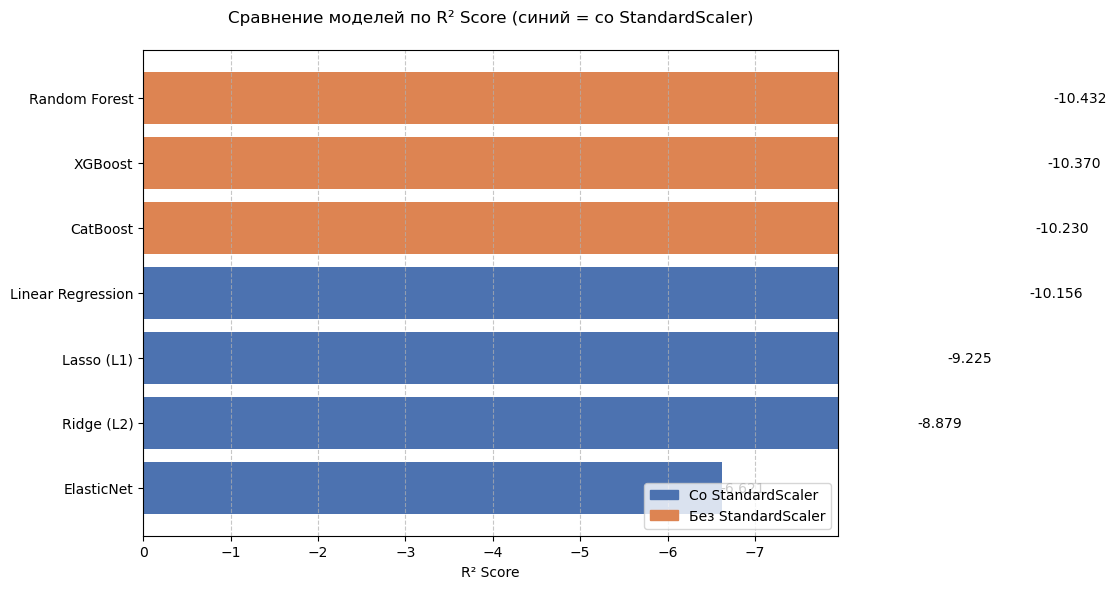

In [19]:
def test_regression_models_with_scaling(X, y, test_size=0.2, random_state=42, verbose=True):
    """
    –¢–µ—Å—Ç–∏—Ä—É–µ—Ç —Ä–µ–≥—Ä–µ—Å—Å–∏–æ–Ω–Ω—ã–µ –º–æ–¥–µ–ª–∏ —Å–æ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∞—Ü–∏–µ–π –¥–∞–Ω–Ω—ã—Ö –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã R¬≤.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pd.DataFrame –∏–ª–∏ np.array
        –ú–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    y : pd.Series –∏–ª–∏ np.array
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    test_size : float, optional
        –†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.2)
    random_state : int, optional
        Seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 42)
    verbose : bool, optional
        –í—ã–≤–æ–¥–∏—Ç—å –ª–∏ –ø—Ä–æ–≥—Ä–µ—Å—Å (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é True)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.DataFrame
        –¢–∞–±–ª–∏—Ü–∞ —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏ R¬≤ –∏ –≤—Ä–µ–º–µ–Ω–µ–º –æ–±—É—á–µ–Ω–∏—è –¥–ª—è –∫–∞–∂–¥–æ–π –º–æ–¥–µ–ª–∏
    """
    
    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–µ–π —Å –ø–∞–π–ø–ª–∞–π–Ω–∞–º–∏ (StandardScaler + –º–æ–¥–µ–ª—å)
    models = {
        'Linear Regression': make_pipeline(StandardScaler(), LinearRegression()),
        'Ridge (L2)': make_pipeline(StandardScaler(), 
                                   Ridge(alpha=1.0, random_state=random_state)),
        'Lasso (L1)': make_pipeline(StandardScaler(), 
                                   Lasso(alpha=0.1, random_state=random_state)),
        'ElasticNet': make_pipeline(StandardScaler(), 
                                   ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=random_state)),
        'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=random_state, n_jobs=-1),
        'CatBoost': CatBoostRegressor(random_state=random_state, verbose=False)
    }
    
    # –°–ª–æ–≤–∞—Ä—å –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    results = {
        'Model': [],
        'R2 Score': [],
        'Train Time (s)': [],
        'Scaler Used': []
    }
    
    # –û–±—É—á–µ–Ω–∏–µ –∏ –æ—Ü–µ–Ω–∫–∞ –º–æ–¥–µ–ª–µ–π
    for name, model in models.items():
        if verbose:
            print(f"üîç –û–±—É—á–µ–Ω–∏–µ {name}...")
        
        try:
            start_time = time.time()
            
            # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏
            model.fit(X_train, y_train)
            train_time = time.time() - start_time
            
            # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
            y_pred = model.predict(X_test)
            
            # –†–∞—Å—á–µ—Ç R¬≤
            r2 = r2_score(y_test, y_pred)
            
            # –û–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è StandardScaler
            scaler_used = 'StandardScaler' if 'standardscaler' in str(model).lower() else 'No'
            
            # –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
            results['Model'].append(name)
            results['R2 Score'].append(r2)
            results['Train Time (s)'].append(train_time)
            results['Scaler Used'].append(scaler_used)
            
            if verbose:
                print(f" {name}\nR¬≤: {r2:.4f} | –í—Ä–µ–º—è: {train_time:.2f}s | Scaler: {scaler_used}")
                print("‚îÄ" * 50)
                
        except Exception as e:
            print(f" –û—à–∏–±–∫–∞ –≤ {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–Ω–∏–µ DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results).sort_values('R2 Score', ascending=False)
    
    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    if verbose:
        plt.figure(figsize=(12, 6))
        colors = ['#4C72B0' if x == 'StandardScaler' else '#DD8452' for x in results_df['Scaler Used']]
        bars = plt.barh(results_df['Model'], results_df['R2 Score'], color=colors)
        
        # –î–æ–±–∞–≤–ª–µ–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏–π –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
        for bar in bars:
            width = bar.get_width()
            plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                    f'{width:.3f}',
                    va='center', ha='left')
        
        plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π –ø–æ R¬≤ Score (—Å–∏–Ω–∏–π = —Å–æ StandardScaler)', pad=20)
        plt.xlabel('R¬≤ Score')
        plt.xlim(0, min(1.1, max(results_df['R2 Score']) * 1.2))
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        
        # –õ–µ–≥–µ–Ω–¥–∞
        import matplotlib.patches as mpatches
        blue_patch = mpatches.Patch(color='#4C72B0', label='–°–æ StandardScaler')
        orange_patch = mpatches.Patch(color='#DD8452', label='–ë–µ–∑ StandardScaler')
        plt.legend(handles=[blue_patch, orange_patch], loc='lower right')
        
        plt.tight_layout()
        plt.show()
    
    return results_df

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results = test_regression_models_with_scaling(X, y)

–ú–æ–¥–µ–ª—å Catboost –ø–æ–∫–∞–∑–∞–ª–∞ –Ω–∞–∏–ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, –±–æ–ª–µ–µ —Ç–æ–≥–æ –Ω–∏–∑–∫–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è —Å —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π —É –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≥–æ–≤–æ—Ä–∏—Ç –æ –Ω–∞–ª–∏—á–∏–∏–∏ –Ω–µ–ª–∏–Ω–µ–π–Ω–æ–π –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏.

–ü–æ–¥–±–∏—Ä–∞–µ–º –Ω–∞–∏–±–æ–ª–µ–µ –∑–Ω–∞—á–∏–º—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π (–Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö)

In [22]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è
def evaluate_model(X, y, model, name, test_size=0.2, random_state=42):
    """
    –û—Ü–µ–Ω–∏–≤–∞–µ—Ç –ø—Ä–æ–∏–∑–≤–æ–¥–∏—Ç–µ–ª—å–Ω–æ—Å—Ç—å –º–æ–¥–µ–ª–∏ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pandas.DataFrame –∏–ª–∏ numpy.ndarray
        –ú–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    y : pandas.Series –∏–ª–∏ numpy.ndarray
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    model : –æ–±—ä–µ–∫—Ç –º–æ–¥–µ–ª–∏ sklearn
        –ú–æ–¥–µ–ª—å –¥–ª—è –æ—Ü–µ–Ω–∫–∏
    test_size : float, optional
        –î–æ–ª—è —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0.2)
    random_state : int, optional
        Seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 42)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    float
        R2 score –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    """
    # –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö –Ω–∞ –æ–±—É—á–∞—é—â—É—é –∏ —Ç–µ—Å—Ç–æ–≤—É—é –≤—ã–±–æ—Ä–∫–∏
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    
    
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        
    else:
        model = models[name]
    # –û–±—É—á–µ–Ω–∏–µ –º–æ–¥–µ–ª–∏ –∏ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º R2 score
    return r2_score(y_test, y_pred)

def find_best_feature_subset(X, y, model, name):
    """
    –ù–∞—Ö–æ–¥–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ø–æ–¥–Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –º–æ–¥–µ–ª–∏ –º–µ—Ç–æ–¥–æ–º –æ–±—Ä–∞—Ç–Ω–æ–≥–æ –∏—Å–∫–ª—é—á–µ–Ω–∏—è.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pandas.DataFrame –∏–ª–∏ numpy.ndarray
        –ú–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    y : pandas.Series –∏–ª–∏ numpy.ndarray
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    model : –æ–±—ä–µ–∫—Ç –º–æ–¥–µ–ª–∏ sklearn
        –ú–æ–¥–µ–ª—å –¥–ª—è –æ—Ü–µ–Ω–∫–∏
    model_name : str
        –ù–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏ (–¥–ª—è –ª–æ–≥–æ–≤)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    dict
        –°–ª–æ–≤–∞—Ä—å —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏:
        - model: –Ω–∞–∑–≤–∞–Ω–∏–µ –º–æ–¥–µ–ª–∏
        - best_r2: –ª—É—á—à–∏–π R2 score
        - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        - num_features: –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
        - selector: –º–µ—Ç–æ–¥ –æ—Ç–±–æ—Ä–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    """
    # –ü—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏–µ numpy array –≤ DataFrame –ø—Ä–∏ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç–∏
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö
    current_features = X.columns.tolist()  # –¢–µ–∫—É—â–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_r2 = evaluate_model(X[current_features], y, model, name)  # –ù–∞—á–∞–ª—å–Ω–∞—è –æ—Ü–µ–Ω–∫–∞
    best_features = current_features.copy()  # –õ—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    history = []  # –ò—Å—Ç–æ—Ä–∏—è –∏–∑–º–µ–Ω–µ–Ω–∏–π
    
    # –ó–∞–ø–∏—Å—å –Ω–∞—á–∞–ª—å–Ω–æ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è
    history.append({
        'features': current_features.copy(),
        'r2': best_r2,
        'action': 'initial'
    })
    
    # –í—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –æ –Ω–∞—á–∞–ª—å–Ω–æ–π –æ—Ü–µ–Ω–∫–µ
    print(f"\n=== {name} ===")
    print(f"Initial R2: {best_r2:.4f} with {len(current_features)} features")
    
    # –û—Å–Ω–æ–≤–Ω–æ–π —Ü–∏–∫–ª –∏—Å–∫–ª—é—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    improved = True
    while improved and len(current_features) > 1:
        improved = False
        worst_feature = None
        
        # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –¥–ª—è –ø–æ–∏—Å–∫–∞ –Ω–∞–∏–º–µ–Ω–µ–µ –∑–Ω–∞—á–∏–º–æ–≥–æ
        for feature in current_features:
            # –ü—Ä–æ–±—É–µ–º –∏—Å–∫–ª—é—á–∏—Ç—å —Ç–µ–∫—É—â–∏–π –ø—Ä–∏–∑–Ω–∞–∫
            trial_features = [f for f in current_features if f != feature]
            current_r2 = evaluate_model(X[trial_features], y, model, name)
            
            # –ó–∞–ø–∏—Å—å –≤ –∏—Å—Ç–æ—Ä–∏—é
            history.append({
                'features': trial_features.copy(),
                'r2': current_r2,
                'action': f'removed {feature}'
            })
            
            # –ï—Å–ª–∏ –∫–∞—á–µ—Å—Ç–≤–æ —É–ª—É—á—à–∏–ª–æ—Å—å, –æ–±–Ω–æ–≤–ª—è–µ–º –ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç
            if current_r2 > best_r2:
                best_r2 = current_r2
                best_features = trial_features.copy()
                worst_feature = feature
                improved = True
        
        # –ï—Å–ª–∏ —É–ª—É—á—à–µ–Ω–∏–µ –±—ã–ª–æ, –∏—Å–∫–ª—é—á–∞–µ–º —Ö—É–¥—à–∏–π –ø—Ä–∏–∑–Ω–∞–∫
        if improved:
            current_features.remove(worst_feature)
    
    # –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    
    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ —Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä–æ–≤–∞–Ω–Ω–æ–º –≤–∏–¥–µ
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'without selection'
    }

def test_all_models(X, y):
    """
    –¢–µ—Å—Ç–∏—Ä—É–µ—Ç –≤—Å–µ –º–æ–¥–µ–ª–∏ –∏–∑ –ø—Ä–µ–¥–æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω–æ–≥–æ —Å–ø–∏—Å–∫–∞.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X : pandas.DataFrame –∏–ª–∏ numpy.ndarray
        –ú–∞—Ç—Ä–∏—Ü–∞ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    y : pandas.Series –∏–ª–∏ numpy.ndarray
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pandas.DataFrame
        DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏ –¥–ª—è –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π
    """
    # –°–ø–∏—Å–æ–∫ —Ç–µ—Å—Ç–∏—Ä—É–µ–º—ã—Ö –º–æ–¥–µ–ª–µ–π —Å –±–∞–∑–æ–≤—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []  # –°–ø–∏—Å–æ–∫ –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
    
    # –¢–µ—Å—Ç–∏—Ä—É–µ–º –∫–∞–∂–¥—É—é –º–æ–¥–µ–ª—å
    for name, model in models:
        try:
            # –ù–∞—Ö–æ–¥–∏–º –ª—É—á—à–∏–π –ø–æ–¥–Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –º–æ–¥–µ–ª–∏
            result = find_best_feature_subset(X, y, model, name)
            results.append(result)
        except Exception as e:
            # –í —Å–ª—É—á–∞–µ –æ—à–∏–±–∫–∏ –≤—ã–≤–æ–¥–∏–º —Å–æ–æ–±—â–µ–Ω–∏–µ –∏ –ø—Ä–æ–¥–æ–ª–∂–∞–µ–º
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞:
results_col_combination = test_all_models(X, y)


=== LinearRegression ===
Initial R2: -10.1557 with 210 features
Best R2: -6.0188 with 124 features
Optimal features: ['MaxAbsEStateIndex', 'MaxEStateIndex', 'MolWt', 'HeavyAtomMolWt', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'Chi1n', 'Chi3n', 'Chi4n', 'Chi4v', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_

In [23]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è, —á–µ—Ä–µ–∑ –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–µ —É–¥–∞–ª–µ–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, —É–ø–æ—Ä—è–¥–æ—á–µ–Ω–Ω—ã—Ö –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –≤–æ–∑–º–æ–∂–Ω—ã—Ö –≤—ã–±—Ä–æ—Å–æ–≤

outliers_count = pd.DataFrame({
        'feature': df.columns,
        'outliers': outliers.sum(axis=0)
    }).sort_values('outliers', ascending=False)
all_features_outliers = outliers_count['feature'][outliers_count['outliers']>0].tolist()
all_features_outliers.remove('IC50, mM')
all_features_outliers.remove('SI')
all_features_outliers.remove('CC50, mM')

def test_all_models(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = get_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_features(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é RandomForest —Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –ø–æ R2
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_r2: –ª—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ R2
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    
    
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features_outliers)+1):
        
        current_features = X.drop(columns = all_features_outliers[:n]).columns.tolist()
        
        current_r2 = evaluate_r2(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'outliers'
    }
def evaluate_r2(X, y, name):
    """
    –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ R2
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    
    
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        
    else:
        model = models[name]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)
    
# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_2 = test_all_models(X, y)


=== LinearRegression ===

Best R2: -1.1430 with 31 features
Optimal features: ['qed', 'SPS', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinAbsPartialCharge', 'AvgIpc', 'SMR_VSA7', 'SMR_VSA8', 'SlogP_VSA9', 'FractionCSP3', 'NumAliphaticHeterocycles', 'NumAromaticCarbocycles', 'fr_Ar_COO', 'fr_HOCCN', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_nitroso', 'fr_phos_acid', 'fr_phos_ester', 'fr_prisulfonamd', 'fr_term_acetylene', 'fr_thiocyan']

=== Ridge ===

Best R2: -1.1256 with 31 features
Optimal features: ['qed', 'SPS', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinAbsPartialCharge', 'AvgIpc', 'SMR_VSA7', 'SMR_VSA8', 'SlogP_VSA9', 'FractionCSP3', 'NumAliphaticHeterocycles', 'NumAromaticCarbocycles', 'fr_Ar_COO', 'fr_HOCCN', 'fr_N_O', 'fr_SH', 'fr_azide', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocya

In [24]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —É—á–µ—Ç–æ–º –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Å –ø–æ–º–æ—â—å—é SHAP

def test_tree_models_sh(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_shap_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_shap_selection(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é RandomForest —Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –ø–æ R2
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_r2: –ª—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ R2
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    feature_names = X.columns.tolist()
    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        explainer = shap.Explainer(model)
        shap_values = explainer(X)
        importance = get_significant_shap_features(shap_values, feature_names)
   
    feat_importance = pd.DataFrame({
        'feature': importance['feature'],
        'importance': importance['mean_abs_shap']
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features)+1):
        
        current_features = all_features[:n]
        current_r2 = evaluate_r2_feature_selection(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'shap_selection'
    }

def evaluate_r2_feature_selection(X, y, model, test_size=0.2, random_state=42):
    """
    –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ R2
    """
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    model = models[model]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)
def get_significant_shap_features(shap_values, feature_names, threshold=0):
    """
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –ø–æ —É–±—ã–≤–∞–Ω–∏—é —Å–ø–∏—Å–æ–∫ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å SHAP-–∑–Ω–∞—á–∏–º–æ—Å—Ç—å—é –≤—ã—à–µ threshold
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    shap_values : shap.Explanation –∏–ª–∏ np.ndarray
        SHAP –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è –≤—Å–µ—Ö –Ω–∞–±–ª—é–¥–µ–Ω–∏–π
    feature_names : list –∏–ª–∏ pd.Index
        –°–ø–∏—Å–æ–∫ –Ω–∞–∑–≤–∞–Ω–∏–π –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    threshold : float, optional
        –ü–æ—Ä–æ–≥ –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é 0)
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.DataFrame: DataFrame —Å –∫–æ–ª–æ–Ω–∫–∞–º–∏ 'feature' –∏ 'mean_abs_shap',
                  –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –ø–æ —É–±—ã–≤–∞–Ω–∏—é –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    # –ï—Å–ª–∏ –ø–µ—Ä–µ–¥–∞–Ω –æ–±—ä–µ–∫—Ç Explanation
    if isinstance(shap_values, shap.Explanation):
        shap_array = shap_values.values
    else:
        shap_array = shap_values
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º —Å—Ä–µ–¥–Ω—é—é –∞–±—Å–æ–ª—é—Ç–Ω—É—é –≤–∞–∂–Ω–æ—Å—Ç—å –ø–æ –≤—Å–µ–º –Ω–∞–±–ª—é–¥–µ–Ω–∏—è–º
    mean_abs_shap = np.abs(shap_array).mean(axis=0)
    
    # –°–æ–∑–¥–∞–µ–º DataFrame
    shap_importance = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })
    
    # –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ –ø–æ—Ä–æ–≥—É –∏ —Å–æ—Ä—Ç–∏—Ä—É–µ–º
    significant_features = shap_importance[shap_importance['mean_abs_shap'] > threshold] \
        .sort_values('mean_abs_shap', ascending=False)
    
    return significant_features.reset_index(drop=True)

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_3 = test_tree_models_sh(X, y)


=== RandomForest ===

Best R2: -10.3062 with 23 features
Optimal features: ['VSA_EState6', 'VSA_EState9', 'VSA_EState8', 'MaxAbsPartialCharge', 'MinPartialCharge', 'BCUT2D_LOGPHI', 'AvgIpc', 'fr_Imine', 'BCUT2D_CHGHI', 'qed', 'VSA_EState2', 'FractionCSP3', 'Kappa3', 'BCUT2D_MWHI', 'MinAbsPartialCharge', 'BertzCT', 'FpDensityMorgan1', 'MaxPartialCharge', 'fr_methoxy', 'MolMR', 'BCUT2D_MRLOW', 'HeavyAtomCount', 'VSA_EState3']

=== XGBoost ===

Best R2: -10.2339 with 13 features
Optimal features: ['VSA_EState6', 'MaxAbsEStateIndex', 'VSA_EState9', 'MaxPartialCharge', 'MinPartialCharge', 'qed', 'MinAbsEStateIndex', 'VSA_EState8', 'SMR_VSA7', 'fr_Al_OH_noTert', 'fr_Imine', 'AvgIpc', 'VSA_EState3']

=== CatBoost ===

Best R2: -10.1353 with 26 features
Optimal features: ['VSA_EState6', 'AvgIpc', 'RingCount', 'SMR_VSA1', 'SlogP_VSA3', 'SMR_VSA7', 'MaxAbsEStateIndex', 'Ipc', 'FpDensityMorgan1', 'VSA_EState5', 'BCUT2D_CHGHI', 'VSA_EState9', 'MinPartialCharge', 'EState_VSA3', 'NumAliphaticHetero

In [25]:
# –ò—â–µ–º –Ω–∞–∏–ª—É—á—à–∏–π –Ω–∞–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å —É—á–µ—Ç–æ–º –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–Ω—ã—Ö —Å –ø–æ–º–æ—â—å—é features importance

def test_tree_models_fs(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    
    results = []
    
    for name, model in models.items():
        try:
            result = get_feature_selection(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_feature_selection(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é RandomForest —Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –ø–æ R2
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_r2: –ª—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ R2
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    feature_names = X.columns.tolist()
    if name == 'RandomForest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
    elif name == 'XGBoost':
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X, y)
        
    elif name == 'CatBoost':
        model = CatBoostRegressor(
        iterations=100,
        random_seed=42,
        verbose=False
        )
        model.fit(X, y)
        
   
    importance = model.feature_importances_
    
    # –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    feat_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    all_features = feat_importance['feature'][feat_importance['importance']>0].tolist()
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_r2 = -np.inf
    best_features = []
    
    for n in range(1, len(all_features)+1):
        
        current_features = all_features[:n]
        current_r2 = evaluate_r2_feature_selection(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        'selector': 'feature_selection'
    }

def evaluate_r2_feature_selection(X, y, model, test_size=0.2, random_state=42):
    """
    –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ R2
    """
    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(silent=True, random_state=42),
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state
    )
    
    model = models[model]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return r2_score(y_test, y_pred)

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_col_combination_4 = test_tree_models_fs(X, y)


=== RandomForest ===

Best R2: -10.2840 with 45 features
Optimal features: ['VSA_EState6', 'VSA_EState9', 'MinAbsPartialCharge', 'MolMR', 'FpDensityMorgan1', 'MaxPartialCharge', 'MaxAbsPartialCharge', 'MinPartialCharge', 'VSA_EState2', 'qed', 'HeavyAtomCount', 'BCUT2D_CHGHI', 'PEOE_VSA8', 'PEOE_VSA9', 'VSA_EState3', 'BCUT2D_LOGPHI', 'BCUT2D_MWLOW', 'AvgIpc', 'Kappa1', 'LabuteASA', 'NumValenceElectrons', 'SPS', 'SlogP_VSA1', 'SlogP_VSA6', 'BCUT2D_MWHI', 'VSA_EState8', 'MolLogP', 'FpDensityMorgan2', 'Kappa2', 'Kappa3', 'BCUT2D_MRLOW', 'Chi0v', 'fr_guanido', 'SMR_VSA3', 'fr_Al_OH_noTert', 'SMR_VSA1', 'HeavyAtomMolWt', 'Chi0', 'Chi2n', 'SMR_VSA2', 'VSA_EState7', 'fr_Al_COO', 'EState_VSA2', 'BCUT2D_CHGLO', 'Ipc']

=== XGBoost ===

Best R2: -10.2679 with 44 features
Optimal features: ['VSA_EState6', 'MaxPartialCharge', 'VSA_EState9', 'NumHDonors', 'fr_methoxy', 'fr_sulfonamd', 'MinAbsEStateIndex', 'MinPartialCharge', 'MaxAbsEStateIndex', 'qed', 'VSA_EState2', 'fr_bicyclic', 'fr_Imine', 'Ber

In [26]:
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å–µ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
results_df = pd.concat([results_col_combination,results_col_combination_2, results_col_combination_3, results_col_combination_4], ignore_index = True)

In [27]:
results_df

model    best_r2  \
0   LinearRegression  -6.018840   
1              Ridge  -0.122802   
2              Lasso  -0.537554   
3         ElasticNet  -0.054392   
4       RandomForest -10.212650   
5            XGBoost -10.300837   
6           CatBoost -10.090355   
7   LinearRegression  -1.142967   
8              Ridge  -1.125615   
9              Lasso  -1.135128   
10        ElasticNet  -0.885901   
11      RandomForest -10.108222   
12           XGBoost -10.067591   
13          CatBoost  -9.934117   
14      RandomForest -10.306188   
15           XGBoost -10.233880   
16          CatBoost -10.135332   
17      RandomForest -10.283951   
18           XGBoost -10.267889   
19          CatBoost -10.154424   

                                        best_features  num_features  \
0   [MaxAbsEStateIndex, MaxEStateIndex, MolWt, Hea...           124   
1   [NumRadicalElectrons, SMR_VSA8, SlogP_VSA9, fr...            18   
2   [MaxAbsEStateIndex, MaxEStateIndex, NumRadical...            25   
3   [qed, NumRadicalElectrons, BCUT2D_MWLOW, Kappa...            36   
4   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           207   
5   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           205   
6   [MaxAbsEStateIndex, MaxEStateIndex, MinAbsESta...           209   
7   [qed, SPS, NumRadicalElectrons, MaxPartialChar...            31   
8   [qed, SPS, NumRadicalElectrons, MaxPartialChar...            31   
9   [qed, SPS, NumRadicalElectrons, MaxPartialChar...            31   
10  [qed, SPS, NumRadicalElectrons, MaxPartialChar...            28   
11  [qed, SPS, NumRadicalElectrons, MaxPartialChar...            62   
12  [qed, SPS, NumRadicalElectrons, MaxPartialChar...            59   
13  [qed, SPS, NumRadicalElectrons, MaxPartialChar...            50   
14  [VSA_EState6, VSA_EState9, VSA_EState8, MaxAbs...            23   
15  [VSA_EState6, MaxAbsEStateIndex, VSA_EState9, ...            13   
16  [VSA_EState6, AvgIpc, RingCount, SMR_VSA1, Slo...            26   
17  [VSA_EState6, VSA_EState9, MinAbsPartialCharge...            45   
18  [VSA_EState6, MaxPartialCharge, VSA_EState9, N...            44   
19  [VSA_EState6, RingCount, SMR_VSA1, AvgIpc, Ber...            30   

             selector  
0   without selection  
1   without selection  
2   without selection  
3   without selection  
4   without selection  
5   without selection  
6   without selection  
7            outliers  
8            outliers  
9            outliers  
10           outliers  
11           outliers  
12           outliers  
13           outliers  
14     shap_selection  
15     shap_selection  
16     shap_selection  
17  feature_selection  
18  feature_selection  
19  feature_selection

In [48]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –Ω–∞–ª—É—á—à–∏–π —Ä–µ–∑—É–ª—å—Ç–∞—Ç —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π
def test_all_models(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = get_res_features(X, y, name)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def get_res_features(X, y, name):
    """
    –û—Ç–±–æ—Ä –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é RandomForest —Å –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–µ–π –ø–æ R2
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    - best_features: —Å–ø–∏—Å–æ–∫ –ª—É—á—à–∏—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    - best_r2: –ª—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ R2
    - all_features: –≤—Å–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –æ—Ç—Å–æ—Ä—Ç–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–æ –≤–∞–∂–Ω–æ—Å—Ç–∏
    """
    
    
    # –ù–∞—Ö–æ–¥–∏–º –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
    best_r2 = -np.inf
    best_features = []
    res_features = results_df['best_features'].tolist()
    for current_features in res_features:
        
        current_r2 = evaluate_r2(X[current_features], y, name)
        if current_r2 > best_r2:
            best_r2 = current_r2
            best_features = current_features.copy()
    
    print(f"\n=== {name} ===\n")
    print(f"Best R2: {best_r2:.4f} with {len(best_features)} features")
    print("Optimal features:", best_features)
    return {
        'model': name,
        'best_r2': best_r2,
        'best_features': best_features,
        'num_features': len(best_features),
        
    }
def evaluate_r2(X, y, name):
    """
    –í—Å–ø–æ–º–æ–≥–∞—Ç–µ–ª—å–Ω–∞—è —Ñ—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—Ü–µ–Ω–∫–∏ R2
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42
    )
    if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
        model = make_pipeline(StandardScaler(), models[name])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return r2_score(y_test, y_pred)
    else:
        if  name == 'CatBoost':
            if len(X_train.columns.tolist()) == 18:
                
                return np.nan
            else:
                model = models[name]
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                return r2_score(y_test, y_pred)
        else:
            model = models[name]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            return r2_score(y_test, y_pred)
    

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_features_selection = test_all_models(X, y)


=== LinearRegression ===

Best R2: -0.0946 with 36 features
Optimal features: ['qed', 'NumRadicalElectrons', 'BCUT2D_MWLOW', 'Kappa3', 'PEOE_VSA2', 'SMR_VSA2', 'SMR_VSA8', 'SlogP_VSA9', 'fr_C_S', 'fr_N_O', 'fr_SH', 'fr_alkyl_halide', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_isocyan', 'fr_isothiocyan', 'fr_lactam', 'fr_morpholine', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperzine', 'fr_prisulfonamd', 'fr_sulfide', 'fr_sulfone', 'fr_thiocyan', 'fr_urea']

=== Ridge ===

Best R2: -0.0933 with 36 features
Optimal features: ['qed', 'NumRadicalElectrons', 'BCUT2D_MWLOW', 'Kappa3', 'PEOE_VSA2', 'SMR_VSA2', 'SMR_VSA8', 'SlogP_VSA9', 'fr_C_S', 'fr_N_O', 'fr_SH', 'fr_alkyl_halide', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_isocyan', 'fr_isothiocyan', 'fr_la

In [50]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ª—É—á—à—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é —Å—Ç—Ä–æ–∫, —É—á–∏—Ç—ã–≤–∞—è —Å—Ç—Ä–æ–∫–∏ —Å –ø–æ–¥–æ–∑—Ä–µ–Ω–∏–µ–º –Ω–∞ –≤—ã–±—Ä–æ—Å—ã, –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π

def test_outlier_strings(X, y,outliers):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_outlier_removal(X, y, outliers,name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_outlier_removal(X, y, outliers,name, model=None):
    """
    –ü–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ —É–¥–∞–ª—è–µ—Ç —Å—Ç—Ä–æ–∫–∏ —Å –≤—ã–±—Ä–æ—Å–∞–º–∏ –∏ –ø—Ä–æ–≤–µ—Ä—è–µ—Ç –≤–ª–∏—è–Ω–∏–µ –Ω–∞ R¬≤
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    df : pd.DataFrame
        –ò—Å—Ö–æ–¥–Ω—ã–π DataFrame —Å –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏
    y : pd.Series
        –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
    outliers_df : pd.DataFrame
        DataFrame —Å —Ñ–ª–∞–≥–∞–º–∏ –≤—ã–±—Ä–æ—Å–æ–≤ (True - –≤—ã–±—Ä–æ—Å)
    model : sklearn –º–æ–¥–µ–ª—å, optional
        –ú–æ–¥–µ–ª—å –¥–ª—è –æ—Ü–µ–Ω–∫–∏ (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é RandomForestRegressor)
    test_size : float, optional
        –†–∞–∑–º–µ—Ä —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏
    random_state : int, optional
        Seed –¥–ª—è –≤–æ—Å–ø—Ä–æ–∏–∑–≤–æ–¥–∏–º–æ—Å—Ç–∏
        
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.DataFrame: –û–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–π DataFrame –±–µ–∑ —É—Ö—É–¥—à–∞—é—â–∏—Ö –∫–∞—á–µ—Å—Ç–≤–æ –≤—ã–±—Ä–æ—Å–æ–≤
    float: –õ—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ R¬≤
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
       
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    removed_indices = []
    
    # –ü–æ–ª—É—á–∞–µ–º –≤—Å–µ –≤—ã–±—Ä–æ—Å—ã
    train_outliers = outliers.loc[X_train.index]
    mask_outliers = ((outliers['SI']) | (outliers['IC50, mM'])| (outliers['CC50, mM']))
    clean_df = train_outliers[mask_outliers]
    
    for idx in clean_df.index.tolist():
        # –í—Ä–µ–º–µ–Ω–Ω–æ —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫—É
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # –û–±—É—á–∞–µ–º –∏ –æ—Ü–µ–Ω–∏–≤–∞–µ–º
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        
        # –†–µ—à–µ–Ω–∏–µ –æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏/—É–¥–∞–ª–µ–Ω–∏–∏ —Å—Ç—Ä–æ–∫–∏
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
            
    print(f"\n=== {name} ===")
    print(f"\n–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: {best_r2:.4f}")
    print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {len(removed_indices)} –∏–∑ {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index,
        'selector': 'outlier_selection'
    }

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_ind_outliers = test_outlier_strings(X, y,outliers)   


=== LinearRegression ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1231
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 81 –∏–∑ 772

=== Ridge ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1230
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 83 –∏–∑ 772

=== Lasso ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1227
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 82 –∏–∑ 772

=== ElasticNet ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1226
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 92 –∏–∑ 772

=== RandomForest ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0000
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 11 –∏–∑ 772

=== XGBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0005
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 64 –∏–∑ 772

=== CatBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.2834
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 28 –∏–∑ 772


In [52]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ª—É—á—à—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é —Å—Ç—Ä–æ–∫ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π –Ω–∞ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö
def test_all_models_strings(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_training_set(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_training_set(X, y, name, model, verbose=True):
    """
    –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç —Å–æ—Å—Ç–∞–≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –ø—É—Ç–µ–º –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–≥–æ —É–¥–∞–ª–µ–Ω–∏—è —Å—Ç—Ä–æ–∫.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X_train, y_train: pd.DataFrame/pd.Series
        –û–±—É—á–∞—é—â–∏–µ –¥–∞–Ω–Ω—ã–µ
    X_test, y_test: pd.DataFrame/pd.Series
        –¢–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏
    model_params: dict
        –ü–∞—Ä–∞–º–µ—Ç—Ä—ã XGBoost (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é: {'n_estimators': 100, 'random_state': 42})
    verbose: bool
        –í—ã–≤–æ–¥–∏—Ç—å –ª–∏ –ø—Ä–æ–≥—Ä–µ—Å—Å
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.Index: –ò–Ω–¥–µ–∫—Å—ã –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –ø–æ–¥–º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ–±—É—á–∞—é—â–∏—Ö –¥–∞–Ω–Ω—ã—Ö
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # –°–æ–∑–¥–∞–µ–º –∫–æ–ø–∏–∏ –¥–ª—è –±–µ–∑–æ–ø–∞—Å–Ω–æ–≥–æ —É–¥–∞–ª–µ–Ω–∏—è —Å—Ç—Ä–æ–∫
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    removed_indices = []
    
    for idx in X_train.index:
        # –í—Ä–µ–º–µ–Ω–Ω–æ —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫—É
        X_temp = X_opt.drop(index=idx)
        y_temp = y_opt.drop(index=idx)
        
        # –û–±—É—á–∞–µ–º –∏ –æ—Ü–µ–Ω–∏–≤–∞–µ–º
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        
        # –†–µ—à–µ–Ω–∏–µ –æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏/—É–¥–∞–ª–µ–Ω–∏–∏ —Å—Ç—Ä–æ–∫–∏
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            removed_indices.append(idx)
            
    print(f"\n=== {name} ===")
    print(f"\n–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: {best_r2:.4f}")
    print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {len(removed_indices)} –∏–∑ {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': removed_indices,
        'num_removed': len(removed_indices),
        'indices': X_opt.index,
        'selector': 'without selection'
    }

# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_ind_combination = test_all_models_strings(X, y)   


=== LinearRegression ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1294
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 199 –∏–∑ 772

=== Ridge ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1291
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 202 –∏–∑ 772

=== Lasso ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1292
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 198 –∏–∑ 772

=== ElasticNet ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1291
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 187 –∏–∑ 772

=== RandomForest ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0000
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 11 –∏–∑ 772

=== XGBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0005
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 64 –∏–∑ 772

=== CatBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1774
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 31 –∏–∑ 772


In [54]:
# –û–±—ä–µ–¥–∏–Ω—è–µ–º –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
results_indices_df = pd.concat([results_ind_outliers, results_ind_combination], ignore_index = True)

In [56]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –Ω–∞–ª—É—á—à—É—é –∫–æ–º–±–∏–Ω–∞—Ü–∏—é —Å—Ç—Ä–æ–∫ –¥–ª—è –ø–æ–≤—ã—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ —Ä–∞–±–æ—Ç—ã –º–æ–¥–µ–ª–µ–π

def test_all_models_strings(X, y):
    """–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ –≤—Å–µ—Ö –º–æ–¥–µ–ª–µ–π –ø–æ –æ—á–µ—Ä–µ–¥–∏"""
    # –°–æ–∑–¥–∞–µ–º –º–æ–¥–µ–ª–∏ —Å –¥–µ—Ñ–æ–ª—Ç–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
    models = [
        ('LinearRegression', LinearRegression()),
        ('Ridge', Ridge(alpha=1.0)),
        ('Lasso', Lasso(alpha=0.1)),
        ('ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5)),
        ('RandomForest', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('XGBoost', XGBRegressor(random_state=42)),
        ('CatBoost', CatBoostRegressor(silent=True, random_state=42))
    ]
    
    results = []
    
    for name, model in models:
        try:
            result = optimize_training_set(X, y, name, model)
            results.append(result)
        except Exception as e:
            print(f"Error with {name}: {str(e)}")
            continue
    
    # –°–æ–∑–¥–∞–µ–º DataFrame —Å —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º–∏
    results_df = pd.DataFrame(results)
    
    
    return results_df
def optimize_training_set(X, y, name, model, verbose=True):
    """
    –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç —Å–æ—Å—Ç–∞–≤ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –ø—É—Ç–µ–º –ø–æ—Å–ª–µ–¥–æ–≤–∞—Ç–µ–ª—å–Ω–æ–≥–æ —É–¥–∞–ª–µ–Ω–∏—è —Å—Ç—Ä–æ–∫.
    
    –ü–∞—Ä–∞–º–µ—Ç—Ä—ã:
    ----------
    X_train, y_train: pd.DataFrame/pd.Series
        –û–±—É—á–∞—é—â–∏–µ –¥–∞–Ω–Ω—ã–µ
    X_test, y_test: pd.DataFrame/pd.Series
        –¢–µ—Å—Ç–æ–≤—ã–µ –¥–∞–Ω–Ω—ã–µ –¥–ª—è –≤–∞–ª–∏–¥–∞—Ü–∏–∏
    model_params: dict
        –ü–∞—Ä–∞–º–µ—Ç—Ä—ã XGBoost (–ø–æ —É–º–æ–ª—á–∞–Ω–∏—é: {'n_estimators': 100, 'random_state': 42})
    verbose: bool
        –í—ã–≤–æ–¥–∏—Ç—å –ª–∏ –ø—Ä–æ–≥—Ä–µ—Å—Å
    
    –í–æ–∑–≤—Ä–∞—â–∞–µ—Ç:
    -----------
    pd.Index: –ò–Ω–¥–µ–∫—Å—ã –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–≥–æ –ø–æ–¥–º–Ω–æ–∂–µ—Å—Ç–≤–∞ –æ–±—É—á–∞—é—â–∏—Ö –¥–∞–Ω–Ω—ã—Ö
    """
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
        'CatBoost': CatBoostRegressor(iterations=100, random_seed=42, verbose=False)
    }
    if name == 'LinearRegression':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][0]]
        
    elif name == 'Ridge':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][1]]
        
    elif name == 'Lasso':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][2]]
    elif name == 'ElasticNet':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][3]]
    elif name == 'RandomForest':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][4]]
    elif name == 'XGBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][5]]
    elif name == 'CatBoost':
        X = X[results_features_selection[results_features_selection['model'] == name]['best_features'][6]]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42
    )
    
    # –°–æ–∑–¥–∞–µ–º –∫–æ–ø–∏–∏ –¥–ª—è –±–µ–∑–æ–ø–∞—Å–Ω–æ–≥–æ —É–¥–∞–ª–µ–Ω–∏—è —Å—Ç—Ä–æ–∫
    X_opt = X_train.copy()
    y_opt = y_train.copy()
    best_r2 = -np.inf
    
    removed_indices = results_indices_df['removed_indices'].tolist()
    
    for idx in removed_indices:
        
        # –í—Ä–µ–º–µ–Ω–Ω–æ —É–¥–∞–ª—è–µ–º —Å—Ç—Ä–æ–∫—É
        X_temp = X_train.drop(idx)
        y_temp = y_train.drop(idx)
        if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
            model = make_pipeline(StandardScaler(), models[name])
        
        else:
            model = models[name]
        model.fit(X_temp, y_temp)
        y_pred = model.predict(X_test)
        current_r2 = r2_score(y_test, y_pred)
        # –†–µ—à–µ–Ω–∏–µ –æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–∏/—É–¥–∞–ª–µ–Ω–∏–∏ —Å—Ç—Ä–æ–∫–∏
        if current_r2 > best_r2:
            best_r2 = current_r2
            X_opt = X_temp
            y_opt = y_temp
            ind = idx
    
    print(f"\n=== {name} ===")
    print(f"\n–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: {best_r2:.4f}")
    print(f"–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: {len(ind)} –∏–∑ {len(X_train)}")
    return {
        'model': name,
        'best_r2': best_r2,
        'removed_indices': ind,
        'num_removed': len(ind),
        'indices': X_opt.index.tolist(),
        'selector': 'without selection'
    }
    
# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_indices_selection = test_all_models_strings(X, y)   


=== LinearRegression ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1294
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 199 –∏–∑ 772

=== Ridge ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1293
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 199 –∏–∑ 772

=== Lasso ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1292
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 199 –∏–∑ 772

=== ElasticNet ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.1291
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 187 –∏–∑ 772

=== RandomForest ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0000
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 11 –∏–∑ 772

=== XGBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: -0.0000
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 11 –∏–∑ 772

=== CatBoost ===

–ò—Ç–æ–≥–æ–≤—ã–π R¬≤: 0.2834
–£–¥–∞–ª–µ–Ω–æ —Å—Ç—Ä–æ–∫: 28 –∏–∑ 772


In [58]:
results_indices_selection

model       best_r2  \
0  LinearRegression  1.293501e-01   
1             Ridge  1.293378e-01   
2             Lasso  1.292019e-01   
3        ElasticNet  1.291490e-01   
4      RandomForest -4.925314e-08   
5           XGBoost -3.177811e-06   
6          CatBoost  2.834015e-01   

                                     removed_indices  num_removed  \
0  [740, 77, 390, 228, 109, 367, 645, 218, 960, 5...          199   
1  [740, 77, 390, 228, 109, 367, 645, 218, 960, 5...          199   
2  [740, 77, 390, 228, 109, 367, 645, 218, 960, 5...          199   
3  [740, 77, 390, 86, 109, 960, 526, 637, 29, 818...          187   
4  [202, 821, 773, 798, 796, 771, 744, 799, 349, ...           11   
5  [740, 202, 773, 798, 796, 771, 739, 799, 520, ...           11   
6  [202, 821, 77, 85, 618, 773, 248, 810, 690, 79...           28   

                                             indices           selector  
0  [202, 317, 957, 309, 821, 457, 117, 999, 245, ...  without selection  
1  [202, 317, 957, 309, 821, 457, 117, 999, 245, ...  without selection  
2  [202, 317, 957, 309, 821, 457, 117, 999, 245, ...  without selection  
3  [202, 317, 957, 309, 821, 457, 117, 999, 245, ...  without selection  
4  [740, 317, 957, 309, 457, 117, 999, 77, 245, 3...  without selection  
5  [317, 957, 309, 821, 457, 117, 999, 77, 245, 3...  without selection  
6  [740, 317, 957, 309, 457, 117, 999, 245, 390, ...  without selection

In [60]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ª–∏–Ω–µ–π–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π

def optimize_linear_model(X_train, X_test, y_train, y_test, model_type='ridge', n_trials=100, random_state=42):
    """
    –û–ø—Ç–∏–º–∏–∑–∏—Ä—É–µ—Ç –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è Ridge, Lasso –∏–ª–∏ ElasticNet —Å –∏—Å–ø—Ä–∞–≤–ª–µ–Ω–∏—è–º–∏.
    """
    
    def objective(trial):
        try:
            alpha = trial.suggest_float('alpha', 1e-6, 100, log=True)
            
            if model_type == 'elasticnet':
                l1_ratio = trial.suggest_float('l1_ratio', 0.01, 0.99)
                model = make_pipeline(StandardScaler(),ElasticNet(
                    alpha=alpha,
                    l1_ratio=l1_ratio,
                    random_state=random_state,
                    max_iter=5000,
                    tol=1e-4,
                    selection='random'
                ))
            elif model_type == 'lasso':
                model = make_pipeline(StandardScaler(),Lasso(
                    alpha=alpha,
                    random_state=random_state,
                    max_iter=5000,
                    tol=1e-4,
                    selection='random'
                ))
            else:  # ridge
                model = make_pipeline(StandardScaler(),Ridge(
                    alpha=alpha,
                    random_state=random_state,
                    max_iter=5000,
                    tol=1e-4
                ))
            
            model.fit( X_train, y_train)
    
            # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
            y_pred = model.predict(X_test)
            
            # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
            #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # –°–æ—Ö—Ä–∞–Ω—è–µ–º R¬≤ –∫–∞–∫ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π –∞—Ç—Ä–∏–±—É—Ç
            #trial.set_user_attr("r2", r2)
            
            return r2
            
        except Exception as e:
            print(f"–û—à–∏–±–∫–∞ –≤ trial: {e}")
            return -np.inf  # –í–æ–∑–≤—Ä–∞—â–∞–µ–º -inf –ø—Ä–∏ –æ—à–∏–±–∫–µ
    
    # –ù–∞—Å—Ç—Ä–æ–π–∫–∞ Optuna
    study = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.TPESampler(seed=random_state),
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
    )
    
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    
    return {
        'best_params': study.best_params,
        'best_score': study.best_value,
        'study': study
    }
    

In [62]:
# –ó–∞–ø—É—Å–∫ –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_ridge = X_train[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]].drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
y_train_ridge = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
X_test_ridge = X_test[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]]
ridge_results = optimize_linear_model(X_train_ridge, X_test_ridge, y_train_ridge, y_test, 'ridge', n_trials=200)

X_train_lasso = X_train[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
y_train_lasso = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
X_test_lasso = X_test[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]]
lasso_results = optimize_linear_model(X_train_lasso, X_test_lasso, y_train_lasso, y_test, 'lasso', n_trials=200)
X_train_elastic = X_train[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
y_train_elastic = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
X_test_elastic = X_test[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]]
elastic_results = optimize_linear_model(X_train_elastic, X_test_elastic, y_train_elastic, y_test, 'elasticnet', n_trials=200)




In [63]:
# –í—ã–≤–æ–¥ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –ø–æ–¥–±–æ—Ä–∞ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è –ª–∏–Ω–µ–π–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π
print(f"Ridge best params: {ridge_results['best_params']}")
print(f"Ridge best R2: {ridge_results['best_score']:.4f}")
print(f"Lasso best params: {lasso_results['best_params']}")
print(f"Lasso best R2: {lasso_results['best_score']:.4f}")
print(f"Elasticnet best params: {elastic_results['best_params']}")
print(f"Elasticnet best R2: {elastic_results['best_score']:.4f}")


Ridge best params: {'alpha': 1.000313191185238e-06}
Ridge best R2: 0.1294
Lasso best params: {'alpha': 1.000313191185238e-06}
Lasso best R2: 0.1294
Elasticnet best params: {'alpha': 0.06324622916151172, 'l1_ratio': 0.2703838075824872}
Elasticnet best R2: 0.1292


In [37]:
# –ü—Ä–æ–≤–µ—Ä–∫–∞ –ø–æ–ª–µ–∑–Ω–æ—Å—Ç–∏ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è –ø–æ–ª–∏–Ω–æ–º–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –¥–ª—è —É–ª—É—á—à–µ–Ω–∏—è –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–π –ª–∏–Ω–µ–π–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π 

def polynomial_regression_with_regularization(X, y):
    

    # –ì–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –ø–æ–ª—É—á–µ–Ω–Ω—ã–µ –ø—Ä–∏ –ø–æ–¥–±–æ—Ä–µ
    ridge_params = {'alpha': ridge_results['best_params']['alpha']}
    lasso_params = {'alpha': lasso_results['best_params']['alpha']}
    elastic_params = {'alpha': elastic_results['best_params']['alpha'], 'l1_ratio': elastic_results['best_params']['l1_ratio']}

    # –ü–µ—Ä–µ–±–∏—Ä–∞–µ–º —Å—Ç–µ–ø–µ–Ω–∏ –ø–æ–ª–∏–Ω–æ–º–∞ –æ—Ç 1 –¥–æ 4
    best_degree = 1
    best_r2 = -np.inf
    results = []

    for degree in range(1, 5):
            
        
        # –û–±—É—á–∞–µ–º –º–æ–¥–µ–ª–∏
        models = {
            'Linear': LinearRegression(),
            'Ridge': Ridge(**ridge_params),
            'Lasso': Lasso(**lasso_params),
            'ElasticNet': ElasticNet(**elastic_params)
        }
        
        degree_results = {'degree': degree}
        
        for name, model in models.items():
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            if name == 'Linear':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]].drop(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['removed_indices'][0])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['removed_indices'][0])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]]
            elif name == 'Ridge':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]].drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Ridge']['removed_indices'][1])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]]
            elif name == 'Lasso':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]].drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'Lasso']['removed_indices'][2])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]]
            elif name == 'ElasticNet':
                X_train = X_train[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]].drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
                y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['removed_indices'][3])
                X_test = X_test[results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]]
            poly = PolynomialFeatures(degree=degree)
            X_poly_train = poly.fit_transform(X_train)
            X_poly_test = poly.transform(X_test)
            if (name == 'LinearRegression') | (name == 'Ridge') | (name == 'Lasso') | (name == 'ElasticNet'):
                model = make_pipeline(StandardScaler(), models[name])
        
            else:
                model = models[name]
            model.fit(X_poly_train, y_train)
            y_pred = model.predict(X_poly_test)
            r2 = r2_score(y_test, y_pred)
            degree_results[name] = r2
            
            # –û–±–Ω–æ–≤–ª—è–µ–º –ª—É—á—à—É—é —Å—Ç–µ–ø–µ–Ω—å –¥–ª—è –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ (–∫–∞–∫ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª–µ)
            if name == 'Linear' and r2 > best_r2:
                best_r2 = r2
                best_degree = degree
        
        results.append(degree_results)
        
        # –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –¥–ª—è —Ç–µ–∫—É—â–µ–π —Å—Ç–µ–ø–µ–Ω–∏
        print(f"\nDegree {degree} results:")
        for name, r2 in degree_results.items():
            if name != 'degree':
                print(f"{name}: R¬≤ = {r2:.4f}")

    print(f"\n–õ—É—á—à–∞—è —Å—Ç–µ–ø–µ–Ω—å –¥–ª—è LinearRegression: {best_degree} (R¬≤ = {best_r2:.3f})")

    # –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –¥–ª—è LinearRegression (–∫–∞–∫ –≤ –æ—Ä–∏–≥–∏–Ω–∞–ª–µ)
    degrees = [res['degree'] for res in results]
    linear_r2 = [res['Linear'] for res in results]
    
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, linear_r2, marker='o', label='Linear Regression')
    
    # –î–æ–±–∞–≤–ª—è–µ–º –¥—Ä—É–≥–∏–µ –º–æ–¥–µ–ª–∏ –Ω–∞ –≥—Ä–∞—Ñ–∏–∫
    for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        model_r2 = [res[model_name] for res in results]
        plt.plot(degrees, model_r2, marker='o', label=model_name)
    
    plt.xlabel('–°—Ç–µ–ø–µ–Ω—å –ø–æ–ª–∏–Ω–æ–º–∞')
    plt.ylabel('R¬≤ –Ω–∞ —Ç–µ—Å—Ç–µ')
    plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Å —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–µ–π')
    plt.legend()
    plt.grid()
    plt.show()

    return results


Degree 1 results:
Linear: R¬≤ = 0.1294
Ridge: R¬≤ = 0.1294
Lasso: R¬≤ = 0.1294
ElasticNet: R¬≤ = 0.1292

Degree 2 results:
Linear: R¬≤ = -5680.8887
Ridge: R¬≤ = -2417.5449
Lasso: R¬≤ = -234.2617
ElasticNet: R¬≤ = -0.1209

Degree 3 results:
Linear: R¬≤ = -683.2966
Ridge: R¬≤ = -141.5923
Lasso: R¬≤ = -12856.0387
ElasticNet: R¬≤ = -2.4435

Degree 4 results:
Linear: R¬≤ = -21913936.7369
Ridge: R¬≤ = -4945.2114
Lasso: R¬≤ = -2132.8458
ElasticNet: R¬≤ = -778.9004

–õ—É—á—à–∞—è —Å—Ç–µ–ø–µ–Ω—å –¥–ª—è LinearRegression: 1 (R¬≤ = 0.129)


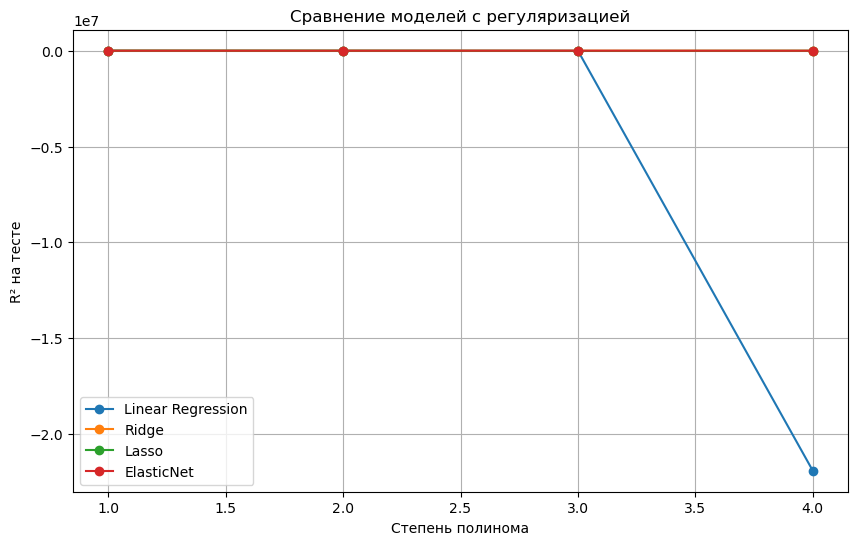

In [38]:
# –ó–∞–ø—É—Å–∫ —Ä–∞—Å—á–µ—Ç–∞
results_test_polinomial_features = polynomial_regression_with_regularization(X, y)

In [66]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è CatBoost

# –ì–ª–æ–±–∞–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –¥–ª—è –¥–∞–Ω–Ω—ã—Ö (–ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ—Ç—Å—è, —á—Ç–æ –æ–Ω–∏ —É–∂–µ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω—ã)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]].drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][6])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['removed_indices'][6])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]]

def objective(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ —Å —É—á–µ—Ç–æ–º RMSE –∏ R¬≤"""
    
    # –ü—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–æ –ø–æ–∏—Å–∫–∞ –¥–ª—è CatBoost
    cb_params = {
        'iterations': trial.suggest_int('catboost_iter', 50, 300),
        'depth': trial.suggest_int('catboost_depth', 2, 10),
        'learning_rate': trial.suggest_float('catboost_lr', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('cb_l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('cb_random_strength', 0.1, 10),
        'bagging_temperature': trial.suggest_float('cb_bagging_temperature', 0.0, 1.0),
        'min_data_in_leaf': trial.suggest_int('cb_min_data_in_leaf', 1, 50),
        'loss_function': 'RMSE',
        'silent': True,
        'thread_count': 4,
        'random_seed': 42
    }

    # –°–æ–∑–¥–∞–Ω–∏–µ –º–æ–¥–µ–ª–µ–π
    catboost = CatBoostRegressor(**cb_params)
    
    # –°–æ–∑–¥–∞–Ω–∏–µ —Å—Ç–µ–∫–∏–Ω–≥-–∞–Ω—Å–∞–º–±–ª—è
    model = StackingRegressor(
        estimators=[
            ('catboost', catboost),
        ],
        n_jobs=-1
    )
    
    # –û–±—É—á–µ–Ω–∏–µ –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    model.fit(X_train, y_train)
    
    # –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö
    y_pred = model.predict(X_test)
    
    # –†–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º R¬≤ –∫–∞–∫ –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π –∞—Ç—Ä–∏–±—É—Ç
    trial.set_user_attr("r2", r2)
    
    return rmse

# –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è Optuna
study = optuna.create_study(
    direction='minimize',  # –ú–∏–Ω–∏–º–∏–∑–∏—Ä—É–µ–º RMSE
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

def log_trial_progress(study, trial):
    """Callback –¥–ª—è –ª–æ–≥–∏—Ä–æ–≤–∞–Ω–∏—è –ø—Ä–æ–≥—Ä–µ—Å—Å–∞ —Å –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏–µ–º RMSE –∏ R¬≤"""
    if trial.number == 0:
        print("| Trial |   RMSE   |   R¬≤    |")
        print("|-------|----------|---------|")
    
    rmse = trial.value if trial.value is not None else float('inf')
    r2 = trial.user_attrs.get("r2", 0.0)
    
    print(f"| {trial.number:5} | {rmse:.6f} | {r2:.6f} |")

# –ó–∞–ø—É—Å–∫ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏
try:
    print("Optimizing CatBoost...")
    study.optimize(
        objective,
        n_trials=200,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

# –ê–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
if len(study.trials) > 0:
    # –ù–∞–π–¥–µ–º trial —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω—ã–º R¬≤ —Å—Ä–µ–¥–∏ –ª—É—á—à–∏—Ö –ø–æ RMSE
    best_trials_cb = sorted(
        [t for t in study.trials if t.value is not None],
        key=lambda x: (x.value, -x.user_attrs["r2"])
    )
    
    best_trial_cb = best_trials_cb[0]
    
    print("\nBest trial:")
    print(f"  RMSE: {best_trial_cb.value:.6f}")
    print(f"  R¬≤: {best_trial_cb.user_attrs['r2']:.6f}")
    print("\nBest params:")
    for key, value in best_trial_cb.params.items():
        print(f"  {key}: {value}")
    
   

Optimizing CatBoost...

Best trial:
  RMSE: 123.769443
  R¬≤: 0.227334

Best params:
  catboost_iter: 73
  catboost_depth: 5
  catboost_lr: 0.23707316494358824
  cb_l2_leaf_reg: 1.0913423041357229
  cb_random_strength: 0.6559343510696384
  cb_bagging_temperature: 0.05532223304751127
  cb_min_data_in_leaf: 18


In [67]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è XGBoost

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]].drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][5])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['removed_indices'][5])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]]

def objective_xgb(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ XGBoost"""
    
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 500),
        'max_depth': trial.suggest_int('xgb_max_depth', 2, 12),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('xgb_subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('xgb_gamma', 0, 5),
        'reg_alpha': trial.suggest_float('xgb_reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('xgb_reg_lambda', 0, 10),
        'random_state': 42,
        'n_jobs': -1
    }

    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("r2", r2)
    return rmse


study_xgb = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

try:
    print("Optimizing XGBoost...")
    study_xgb.optimize(
        objective_xgb,
        n_trials=200,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

if len(study_xgb.trials) > 0:
    best_trial_xg = study_xgb.best_trial
    print("\nBest XGBoost params:")
    for key, value in best_trial_xg.params.items():
        print(f"  {key}: {value}")
    print(f"Best RMSE: {best_trial_xg.value:.6f}")
    print(f"Best R¬≤: {best_trial_xg.user_attrs['r2']:.6f}")
    
   

Optimizing XGBoost...

Best XGBoost params:
  xgb_n_estimators: 78
  xgb_max_depth: 9
  xgb_learning_rate: 0.01248125728258348
  xgb_subsample: 0.8557238591092615
  xgb_colsample_bytree: 0.645715425593831
  xgb_gamma: 0.3085376774243438
  xgb_reg_alpha: 6.891330397702679
  xgb_reg_lambda: 8.028385560974613
Best RMSE: 140.804863
Best R¬≤: -0.000000


In [68]:
# –ü–æ–¥–±–æ—Ä –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è RandomForest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]].drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][4])
y_train = y_train.drop(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['removed_indices'][4])
X_test = X_test[results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]]

def objective_rf(trial):
    """–§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ RandomForest"""
    
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 50, 500),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('rf_max_features', 0.1, 1.0),
        'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**rf_params)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    trial.set_user_attr("r2", r2)
    return rmse


study_rf = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_warmup_steps=5)
)

try:
    print("Optimizing RandomForest...")
    study_rf.optimize(
        objective_rf,
        n_trials=200,
        #callbacks=[log_trial_progress],
        gc_after_trial=True
    )
except KeyboardInterrupt:
    print("\nOptimization stopped by user")

if len(study_rf.trials) > 0:
    best_trial_rf = study_rf.best_trial
    print("\nBest RandomForest params:")
    for key, value in best_trial_rf.params.items():
        print(f"  {key}: {value}")
    print(f"Best RMSE: {best_trial_rf.value:.6f}")
    print(f"Best R¬≤: {best_trial_rf.user_attrs['r2']:.6f}")



Optimizing RandomForest...

Best RandomForest params:
  rf_n_estimators: 242
  rf_max_depth: 28
  rf_min_samples_split: 12
  rf_min_samples_leaf: 7
  rf_max_features: 0.40366191403551677
  rf_bootstrap: True
Best RMSE: 140.804863
Best R¬≤: -0.000000


In [76]:
# –°–æ–±–∏—Ä–∞–µ–º –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
best_results_total = []
linear = {
        'model': results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['model'][0],
        'best_r2': round(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['best_r2'][0], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'LinearRegression']['best_features'][0]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'LinearRegression']['indices'][0])
    }
best_results_total.append(linear)
ridge = {
        'model': results_indices_selection[results_indices_selection['model'] == 'Ridge']['model'][1],
        'best_r2': round(ridge_results['best_score'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'Ridge']['best_features'][1]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'Ridge']['indices'][1])
    }
best_results_total.append(ridge)
lasso = {
        'model': results_indices_selection[results_indices_selection['model'] == 'Lasso']['model'][2],
        'best_r2': round(lasso_results['best_score'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'Lasso']['best_features'][2]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'Lasso']['indices'][2])
    }
best_results_total.append(lasso)
elastic = {
        'model': results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['model'][3],
        'best_r2': round(elastic_results['best_score'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'ElasticNet']['best_features'][3]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'ElasticNet']['indices'][3])
    }
best_results_total.append(elastic)
rf = {
        'model': results_indices_selection[results_indices_selection['model'] == 'RandomForest']['model'][4],
        'best_r2': round(best_trial_rf.user_attrs['r2'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'RandomForest']['best_features'][4]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'RandomForest']['indices'][4])
    }
best_results_total.append(rf)
xg = {
        'model': results_indices_selection[results_indices_selection['model'] == 'XGBoost']['model'][5],
        'best_r2': round(best_trial_xg.user_attrs['r2'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'XGBoost']['best_features'][5]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'XGBoost']['indices'][5])
    }
best_results_total.append(xg)
cb = {
        'model': results_indices_selection[results_indices_selection['model'] == 'CatBoost']['model'][6],
        'best_r2': round(best_trial_cb.user_attrs['r2'], 5),
        'count_features': len(results_features_selection[results_features_selection['model'] == 'CatBoost']['best_features'][6]),
        'count_strings': len(results_indices_selection[results_indices_selection['model'] == 'CatBoost']['indices'][6])
    }
best_results_total.append(cb)

best_results_total_df = pd.DataFrame(best_results_total)

In [78]:
# –õ—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
best_results_total_df

model  best_r2  count_features  count_strings
0  LinearRegression  0.12935              36            573
1             Ridge  0.12935              36            573
2             Lasso  0.12935              36            573
3        ElasticNet  0.12920              36            585
4      RandomForest -0.00000              18            761
5           XGBoost -0.00000              18            761
6          CatBoost  0.22733              50            744